In [67]:
from lib.policy_guided_explorer import Explorer
from lib.implicit_mdp import PTO_wrapper
from lib.models.generic_v1.model import SingleAgent as G1Model

In [68]:
from lib.models.generic_v1.protocols.bitcoin import Protocol as G1Bitcoin
from lib.models.generic_v1.protocols.ghostdag import Protocol as G1Ghostdag

protocols = dict(
    bitcoin=lambda: G1Bitcoin(),
    ghostdag_1=lambda: G1Ghostdag(k=1),
    ghostdag_2=lambda: G1Ghostdag(k=2),
    ghostdag_3=lambda: G1Ghostdag(k=3),
)

# Stage 0: Can we get some results for GhostDAG?

In [69]:
evaluations = []


def evaluate(m, m_honest):
    res = m.value_iteration(stop_delta=0.00001)
    res["episode_reward"] = sum(res["vi_value"][s] * p for s, p in m.start.items())
    res["episode_progress"] = sum(res["vi_progress"][s] * p for s, p in m.start.items())
    res["reward_per_progress"] = res["episode_reward"] / res["episode_progress"]

    res["fully_honest"] = all(a < 1 for a in res["vi_policy"])
    # It at first came unexpeted to me, that vi_policy has dishonest entries while the honest policy was optimal.
    # Turns out the dishonest behavior happens on states that cannot be reached from the honest policy.
    # I'm now comparing the policies for only these states which can be rewach from the honest policy.
    # If the agent acts honest on these states it acts honest everywhere.
    res["honest"] = all(a < 1 for a in res["vi_policy"][: m_honest.n_states])
    return res

In [70]:
def bisect_alpha(*, protocol, gamma, horizon, distance, precision, verbose=False):
    upper_alpha = 1
    lower_alpha = 0
    for i in range(precision):
        alpha = (upper_alpha + lower_alpha) / 2
        base_model = G1Model(protocols[protocol], alpha=alpha, gamma=gamma)
        pto_model = PTO_wrapper(base_model, horizon=horizon, terminal_state=b"terminal")

        attack_found = False
        e = Explorer(pto_model, pto_model.honest)
        m_honest = e.mdp()
        for d in range(1, distance + 1):
            e.explore_aside_policy()  # increase distance by one
            m = e.mdp()

        res = evaluate(m, m_honest)
        evaluations.append(
            dict(
                precision=precision,
                precision_i=i,
                gamma=gamma,
                protocol=protocol,
                distance=distance,
                alpha=alpha,
                horizon=horizon,
                **res,
            )
        )

        attack_found = res["reward_per_progress"] > alpha
        attack_found = not res["honest"]

        # if res["honest"]:
        if verbose and attack_found:
            print(f"   attack for alpha={alpha} w/ rpp={rpp}")
        if verbose and not attack_found:
            print(f"no attack for alpha={alpha}")

        if attack_found:
            upper_alpha = alpha
        else:
            lower_alpha = alpha

In [71]:
import seaborn
import pandas


def upper_results():
    return seaborn.relplot(
        data=pandas.DataFrame(evaluations).query("reward_per_progress > alpha"),
        x="gamma",
        y="alpha",
        hue="protocol",
        style="distance",
        col="horizon",
    )

In [72]:
def explore_gen():
    for distance in range(1, 4):
        for gamma in [0.5, 0, 1]:
            for protocol in protocols.keys():
                yield dict(
                    protocol=protocol,
                    gamma=gamma,
                    horizon=30,
                    distance=distance,
                    precision=10,
                )

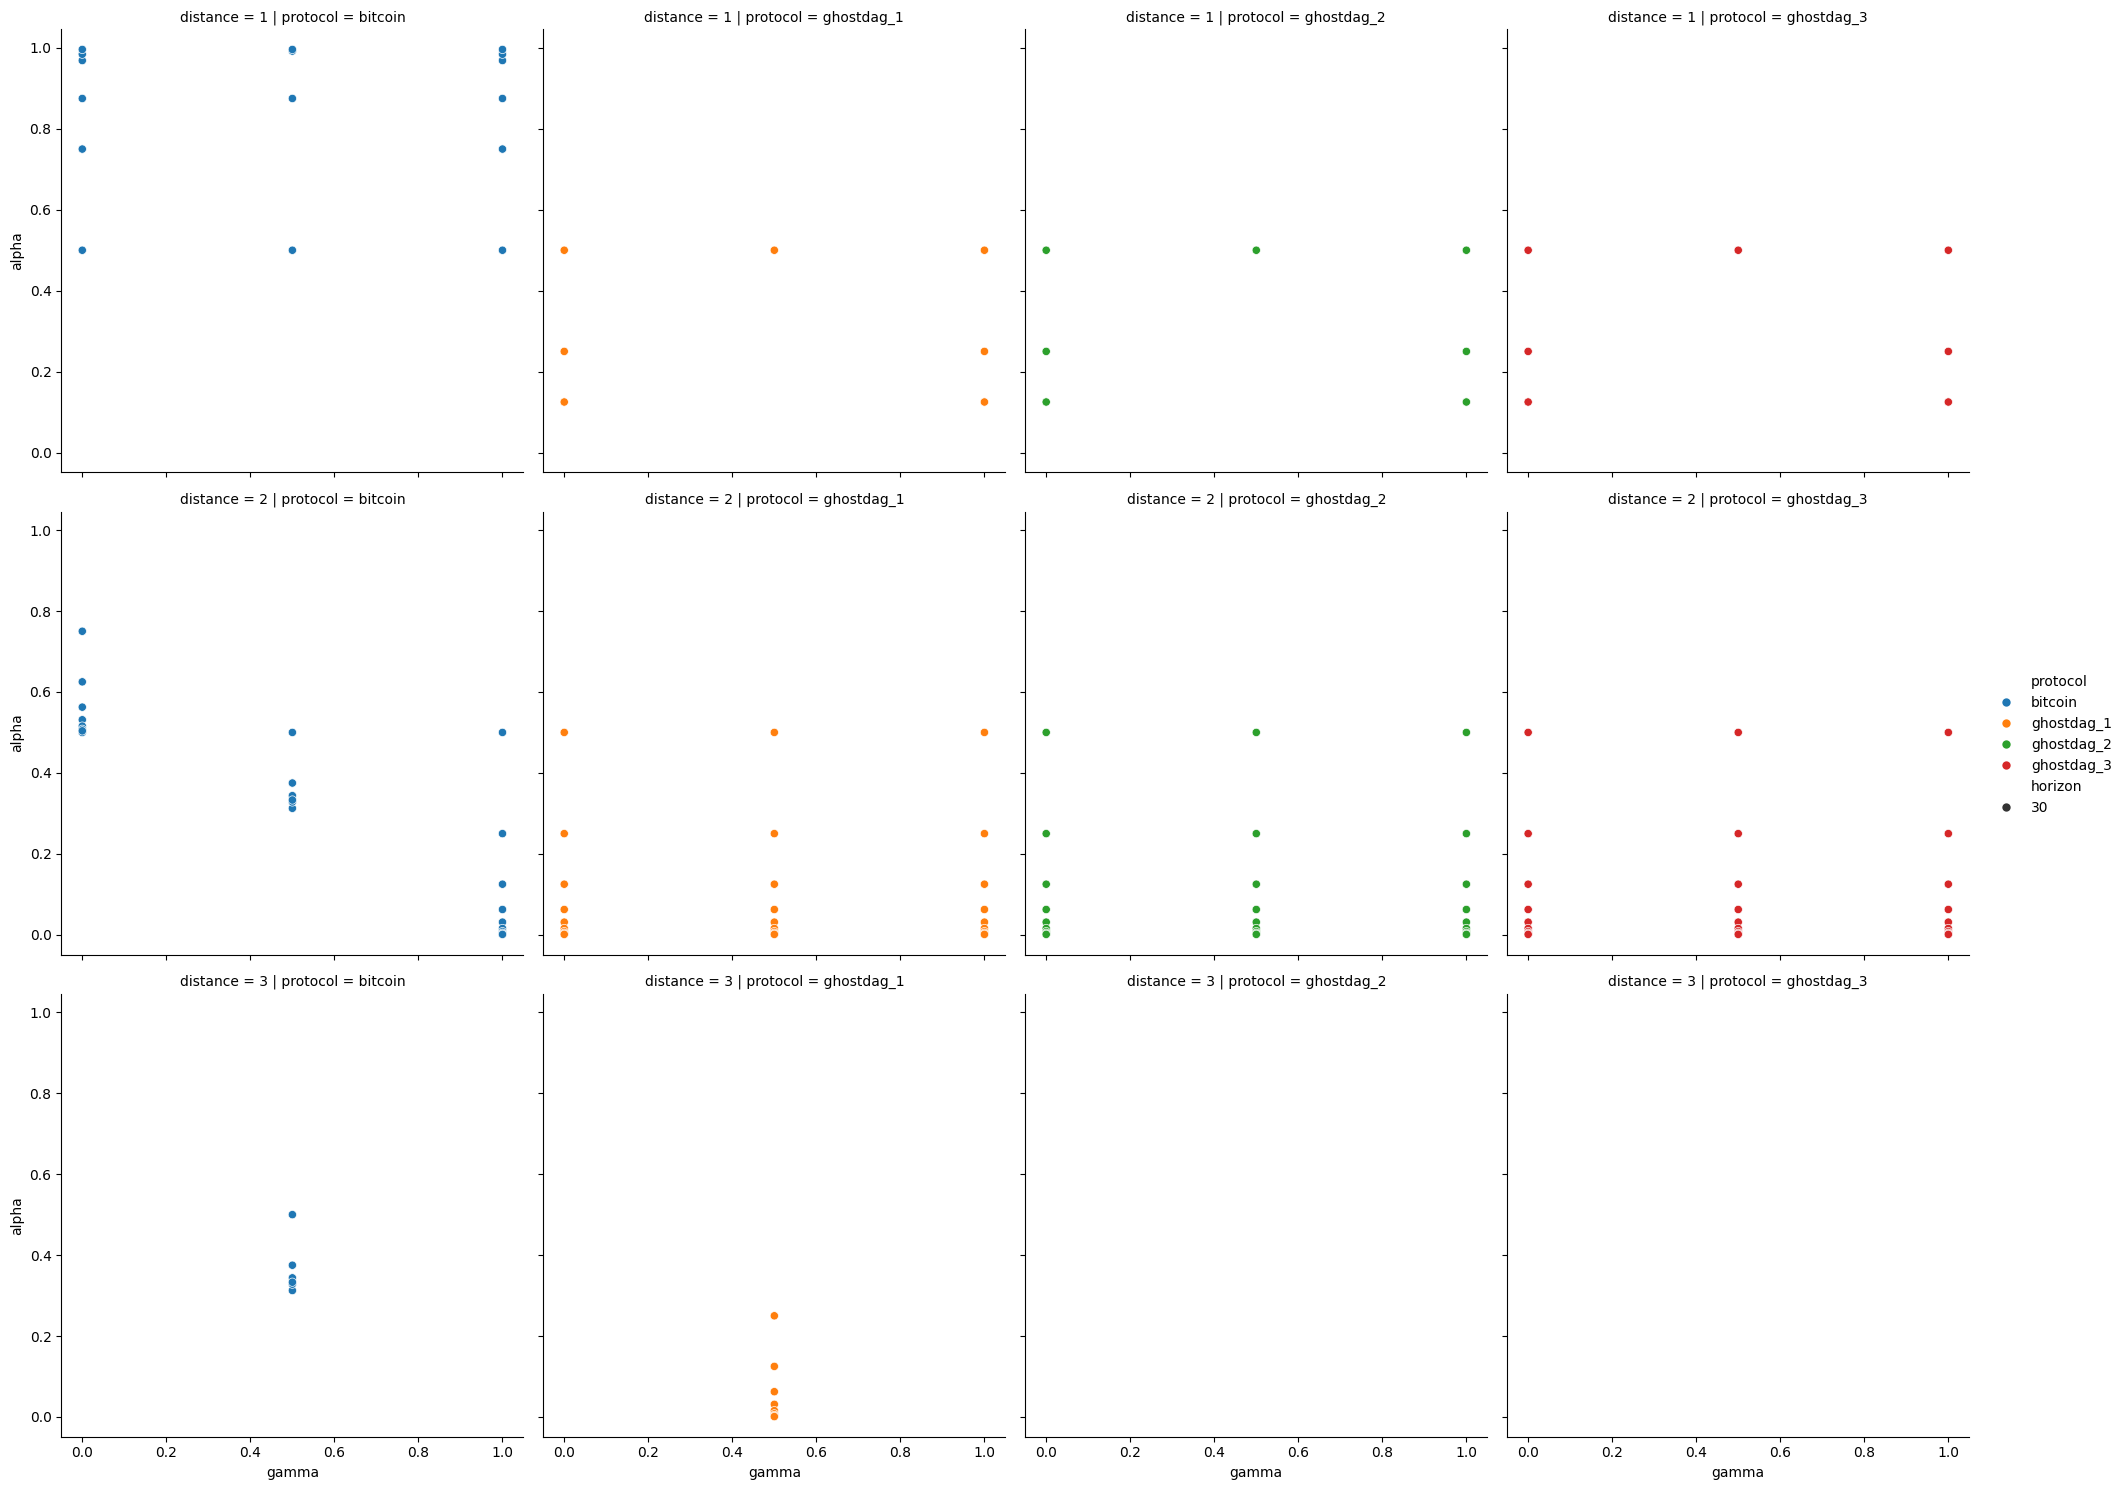

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f5cd624b4c0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

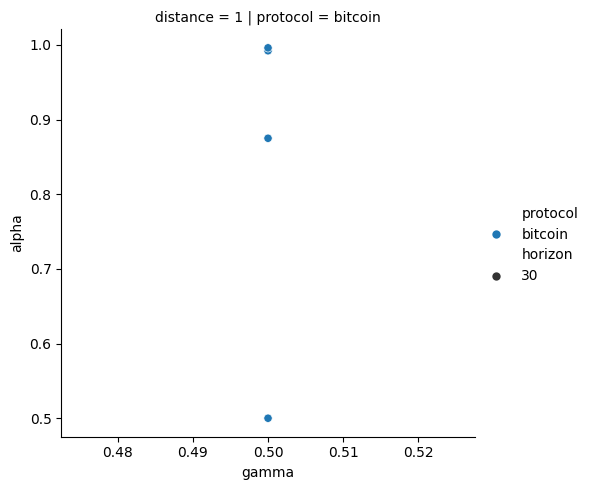

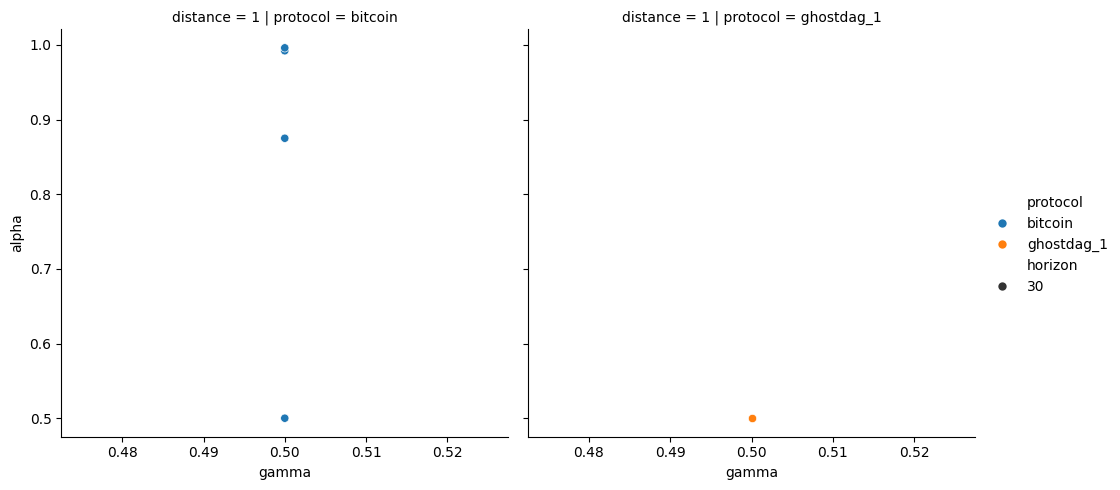

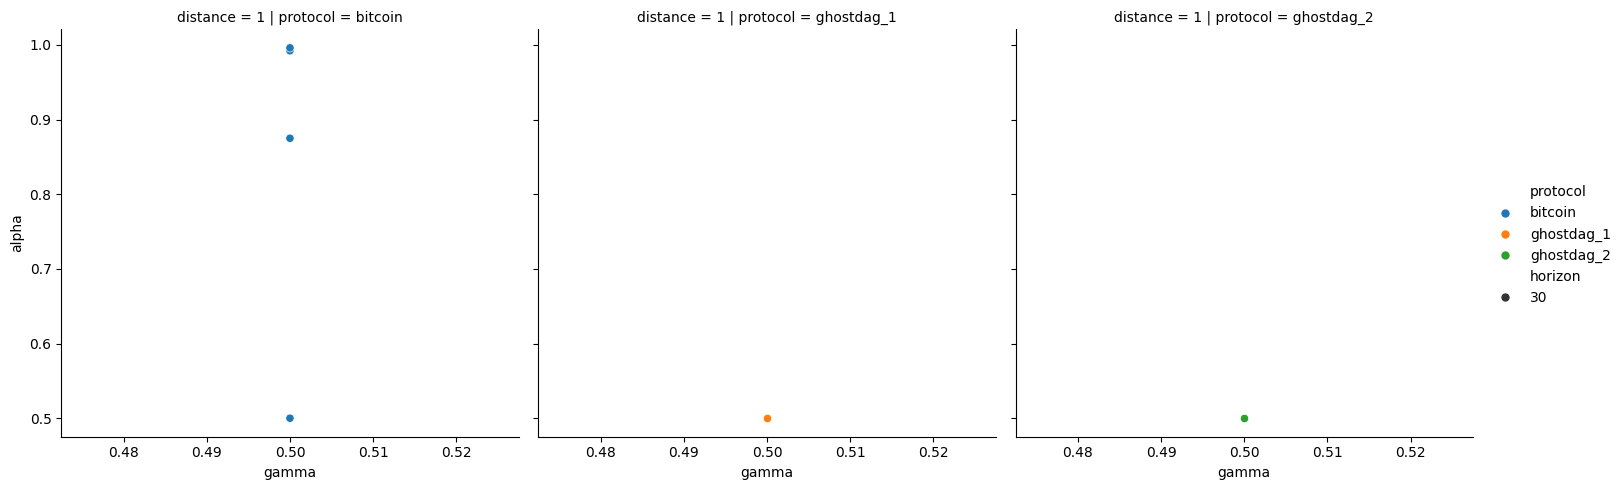

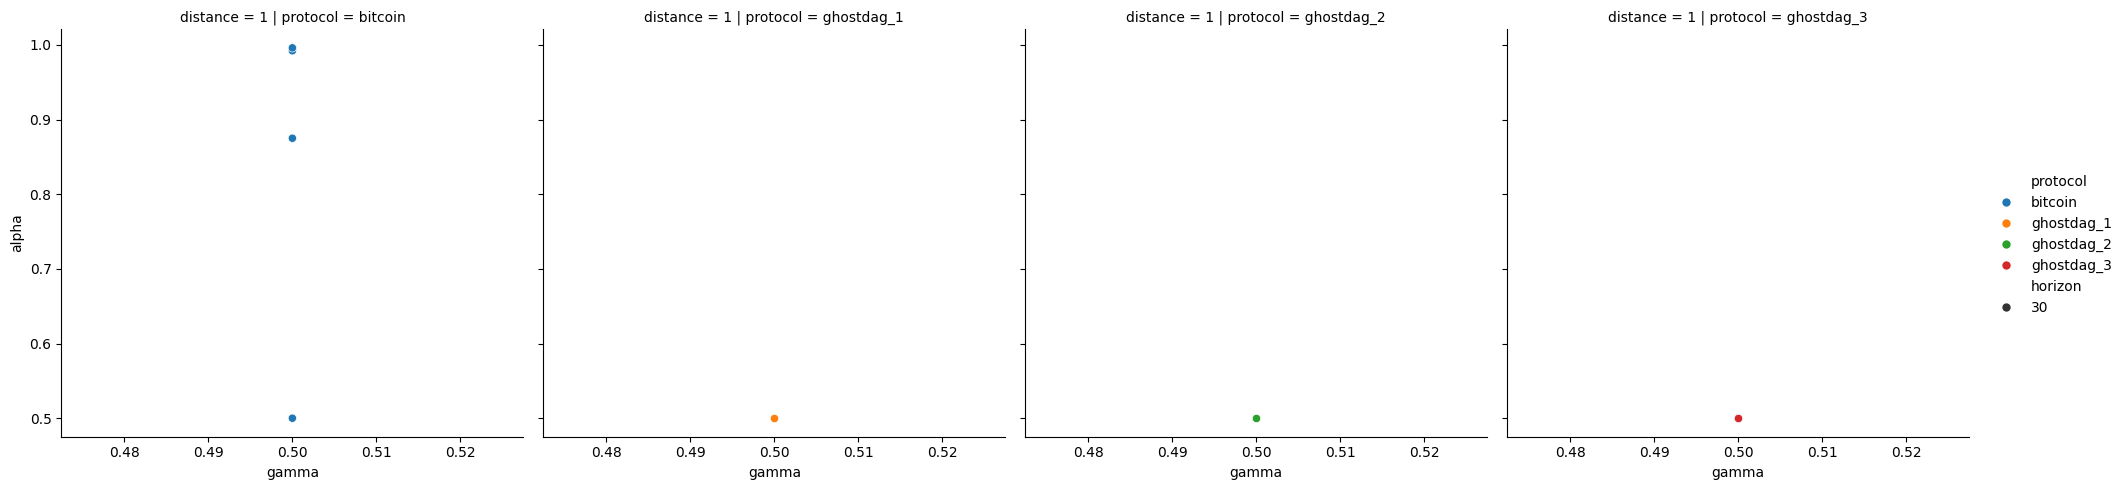

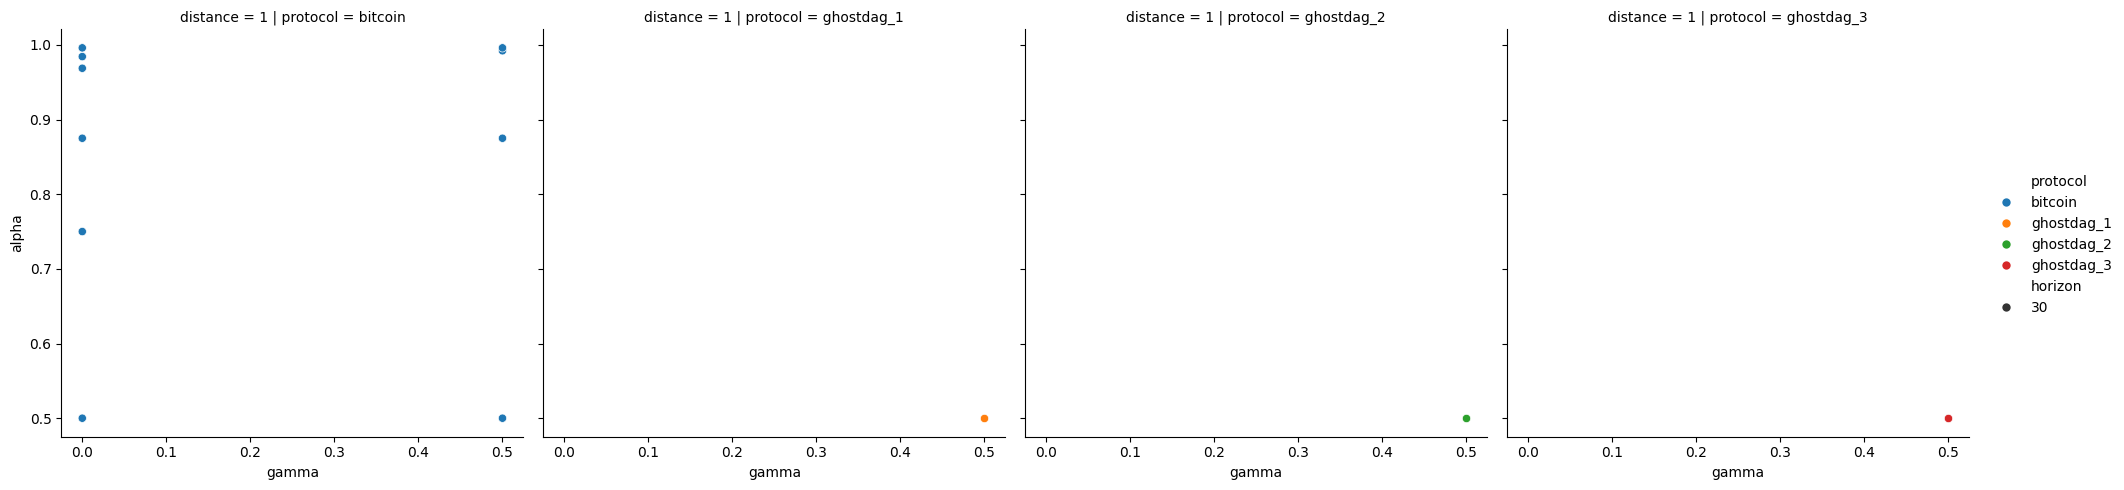

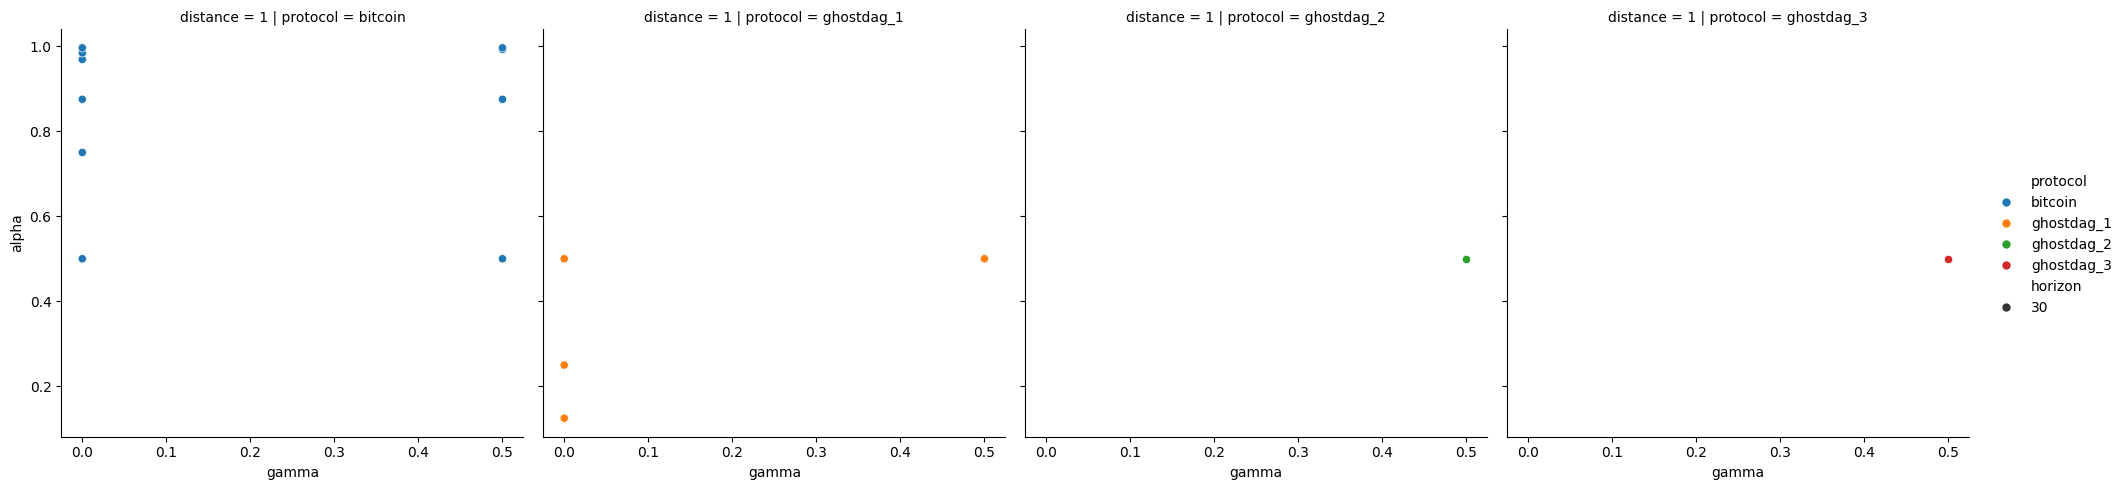

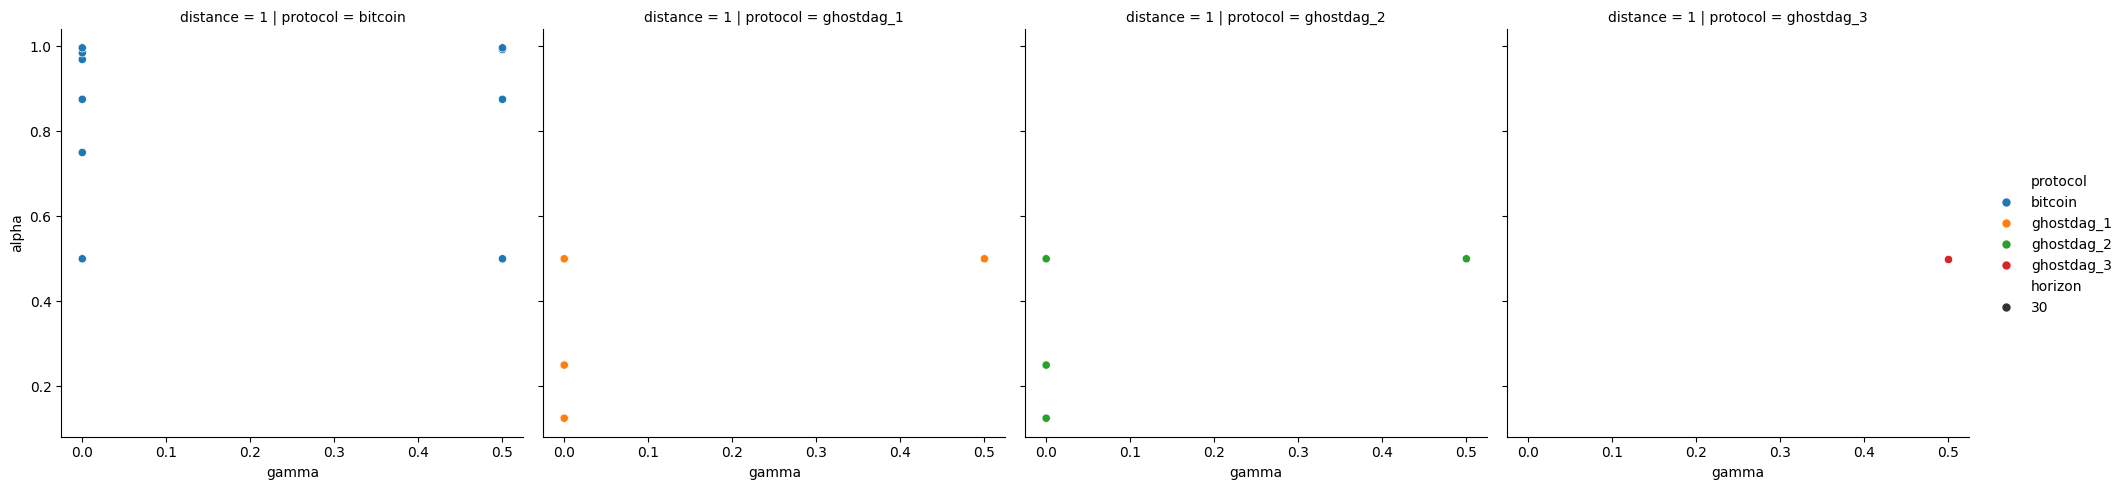

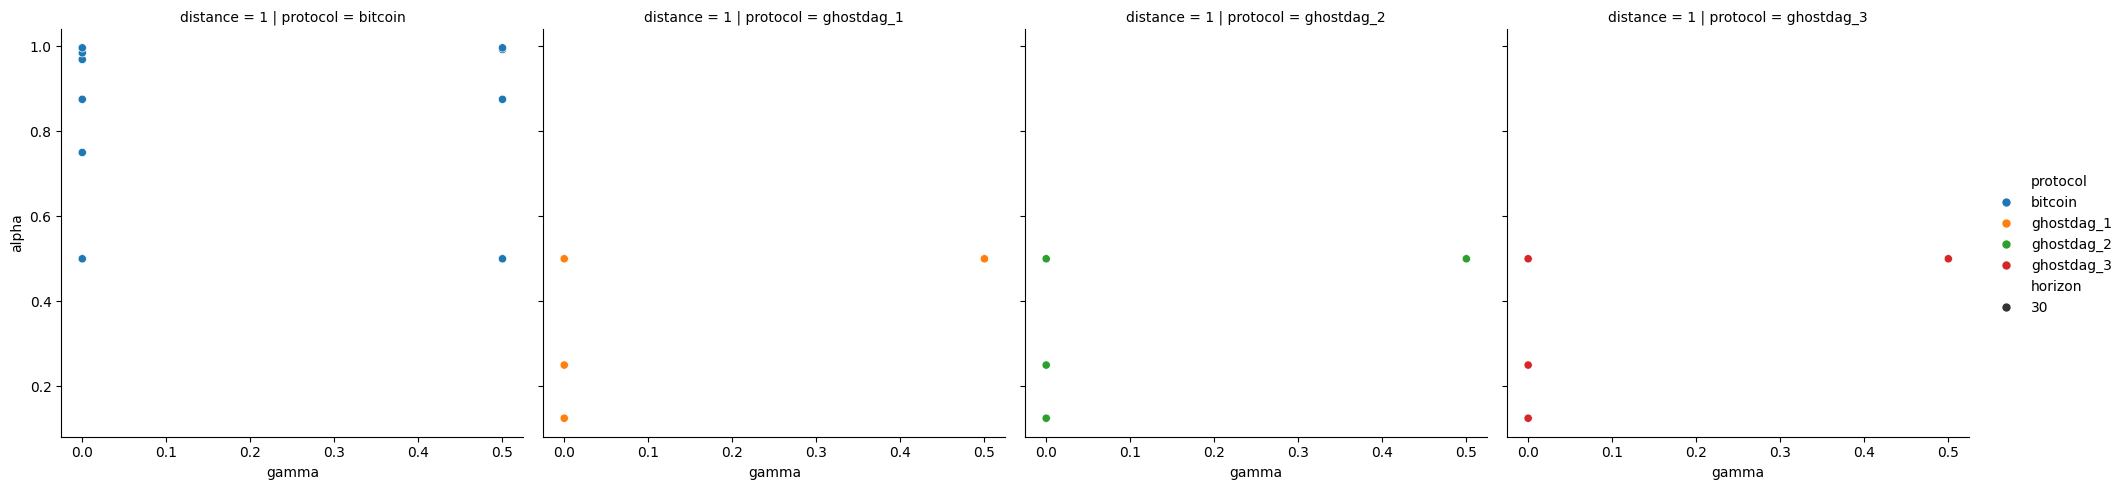

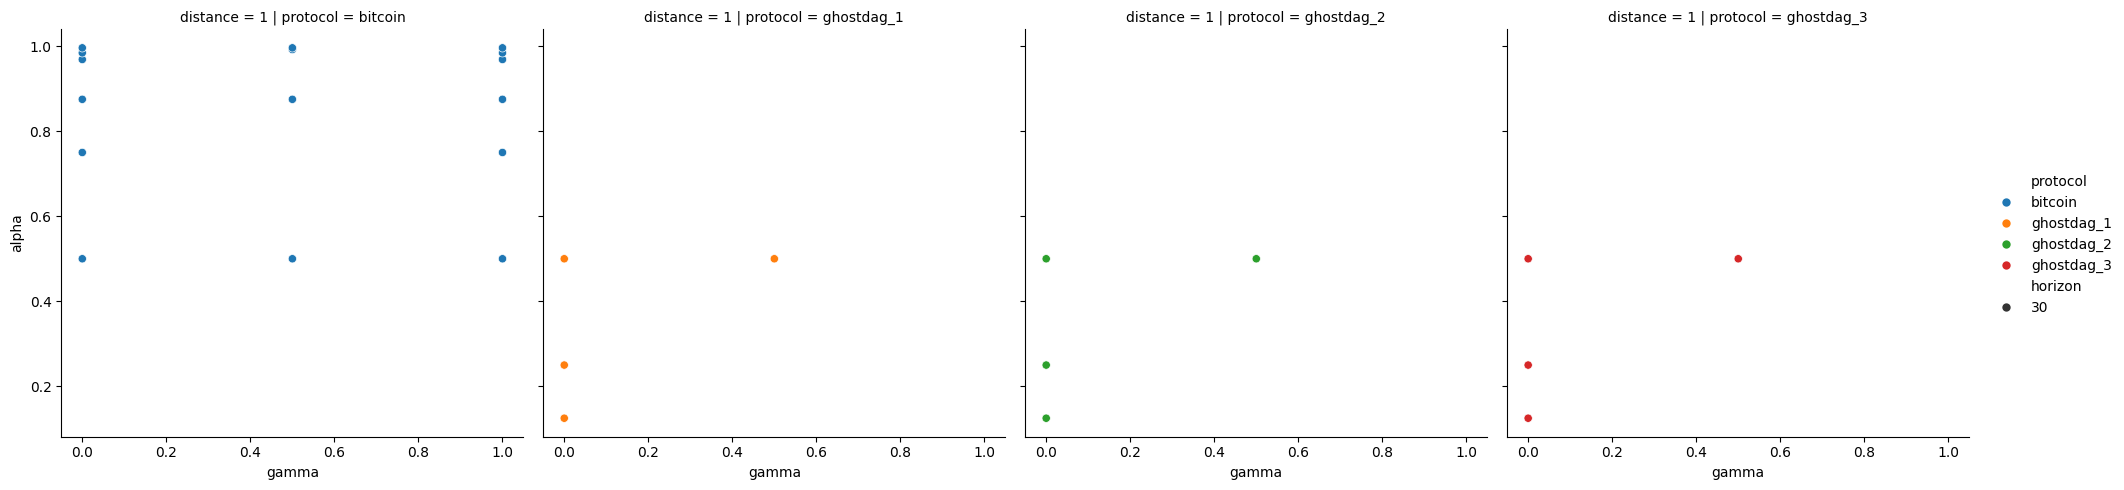

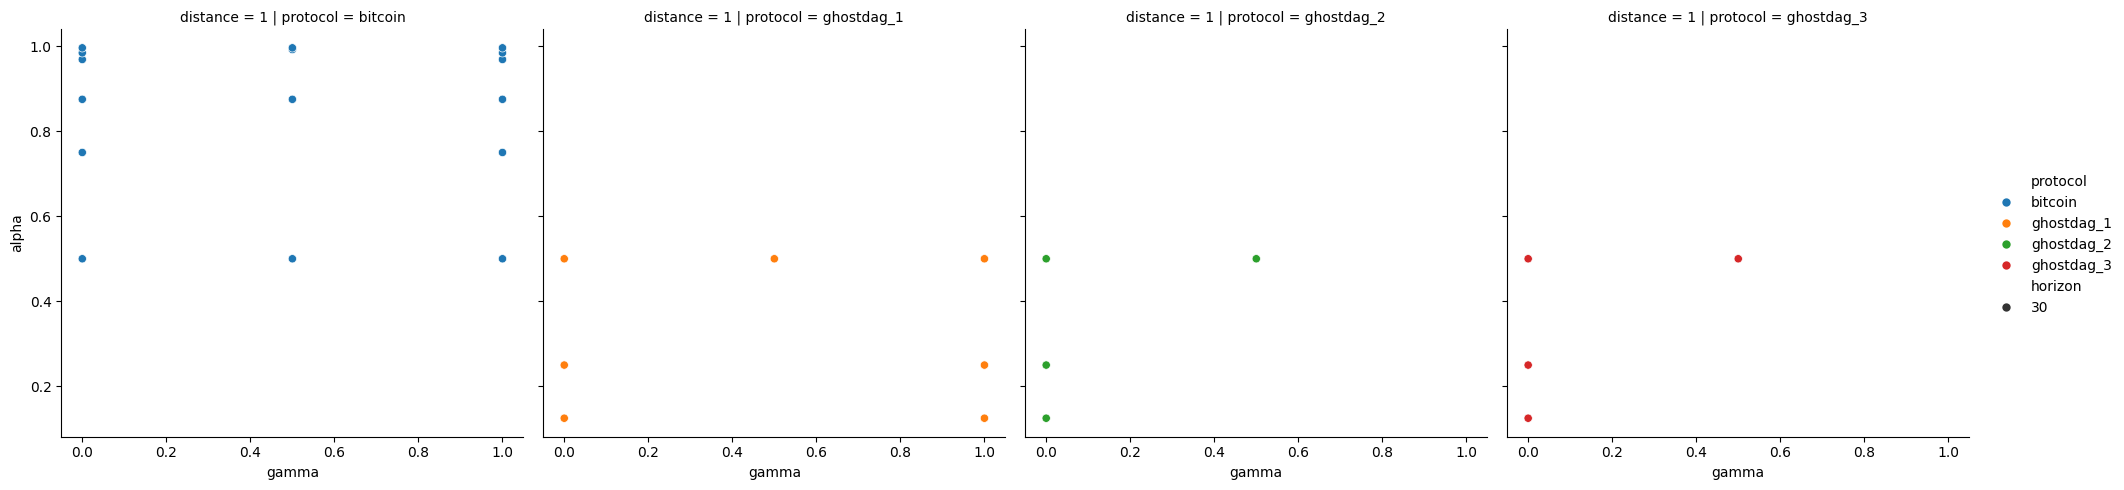

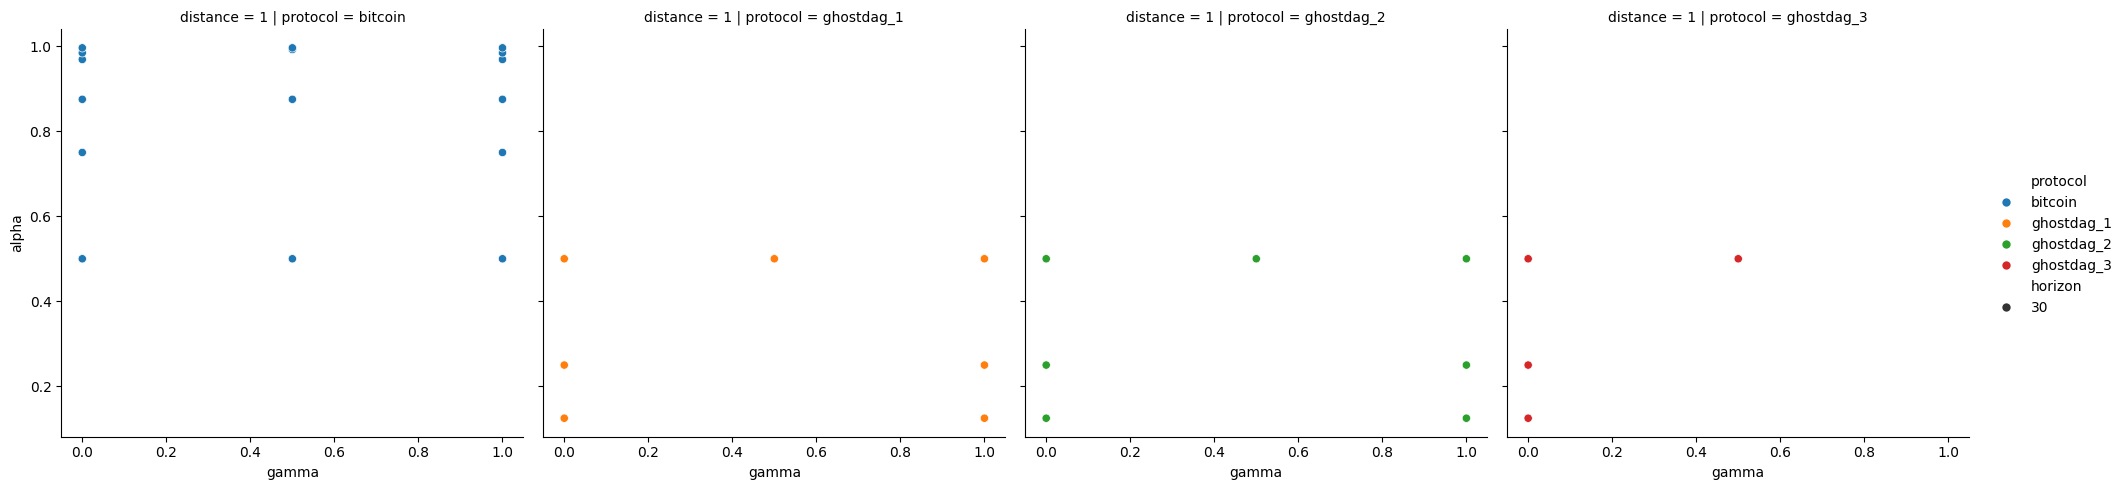

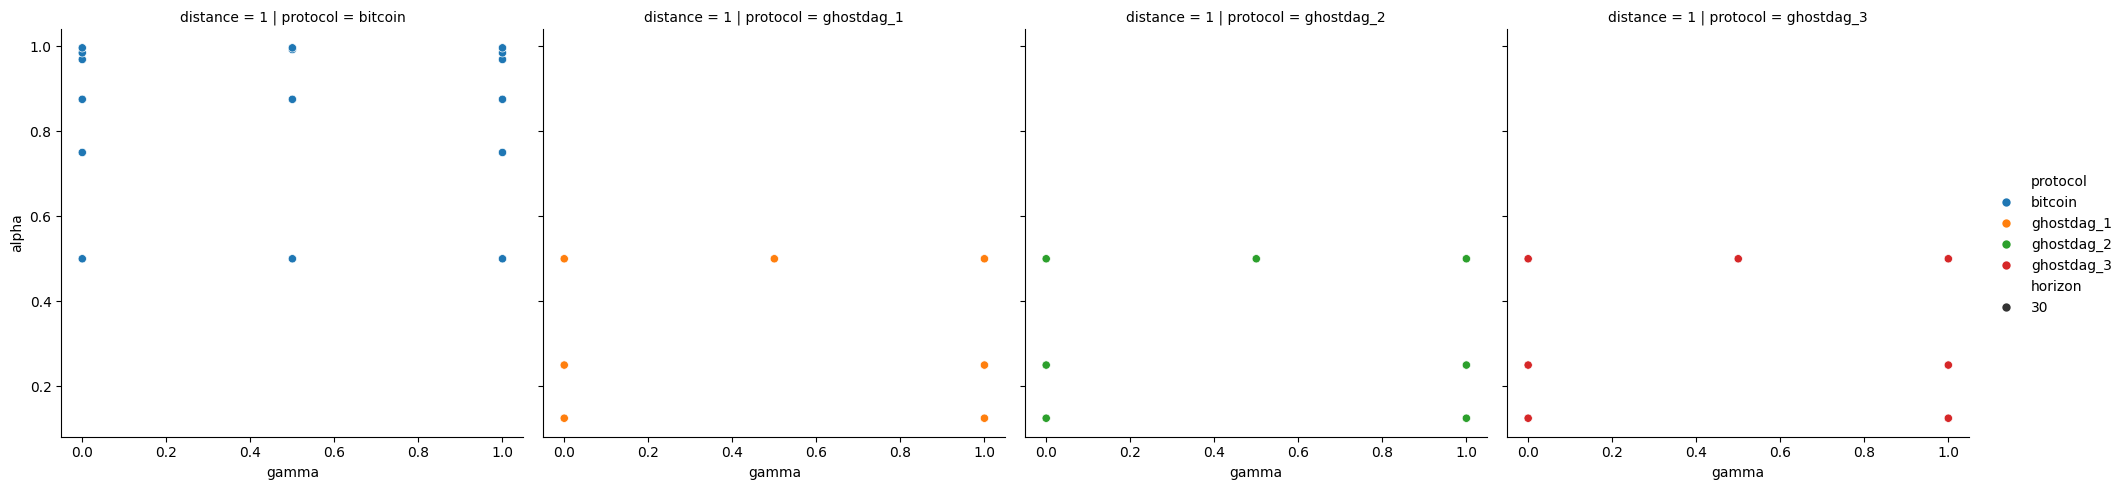

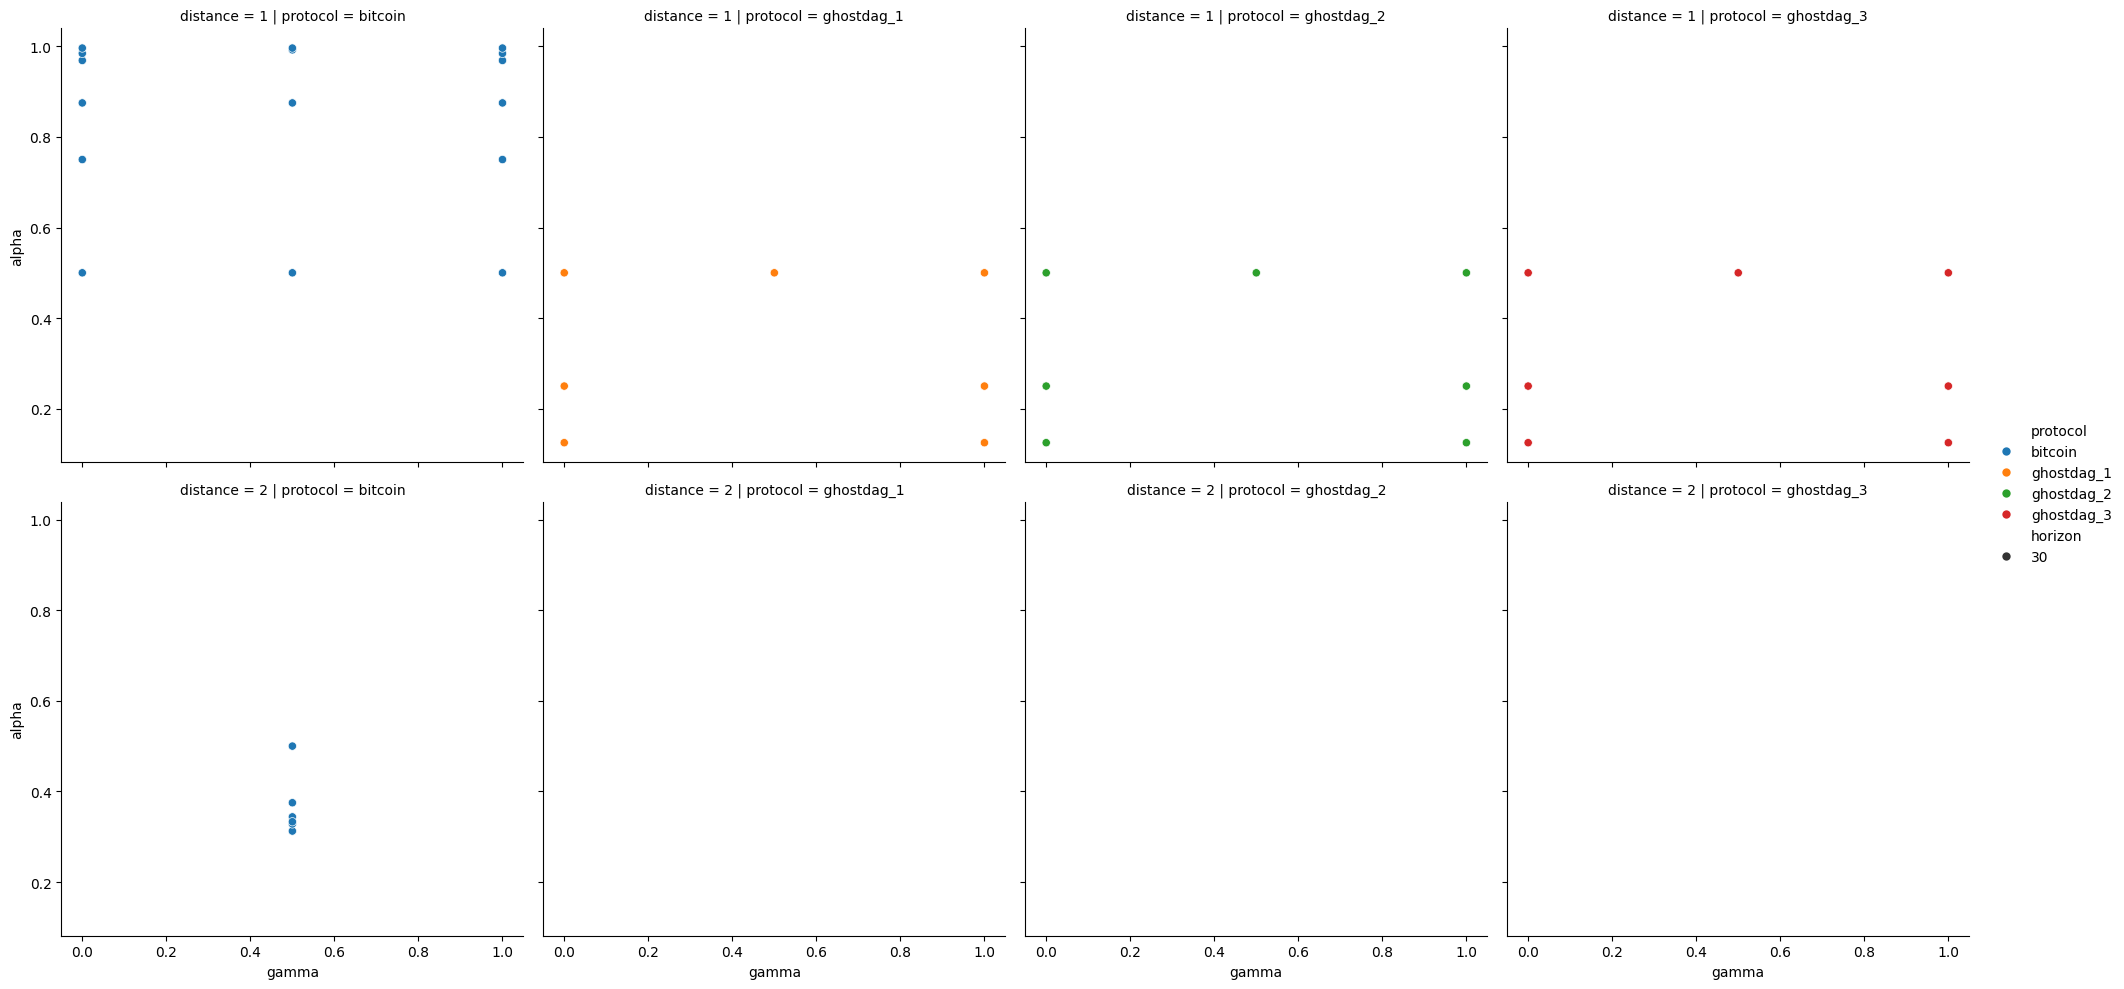

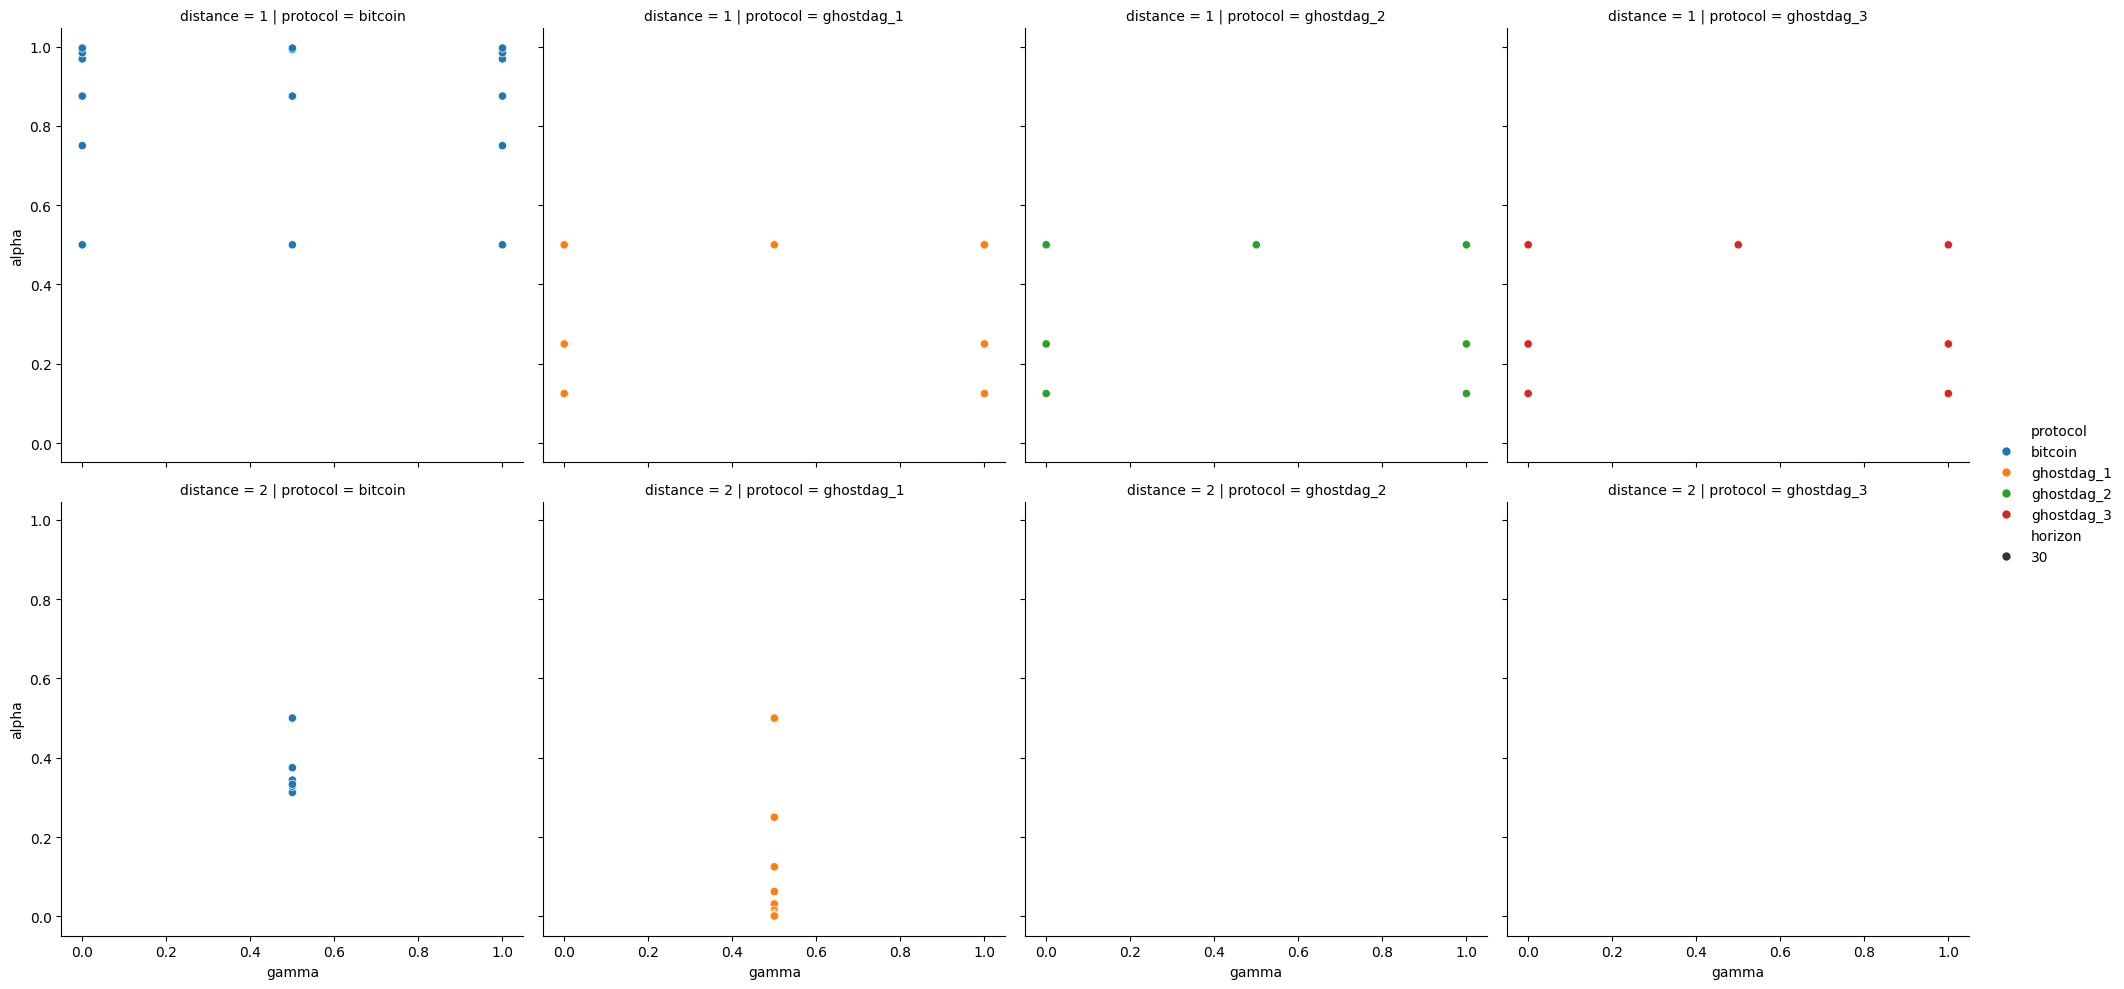

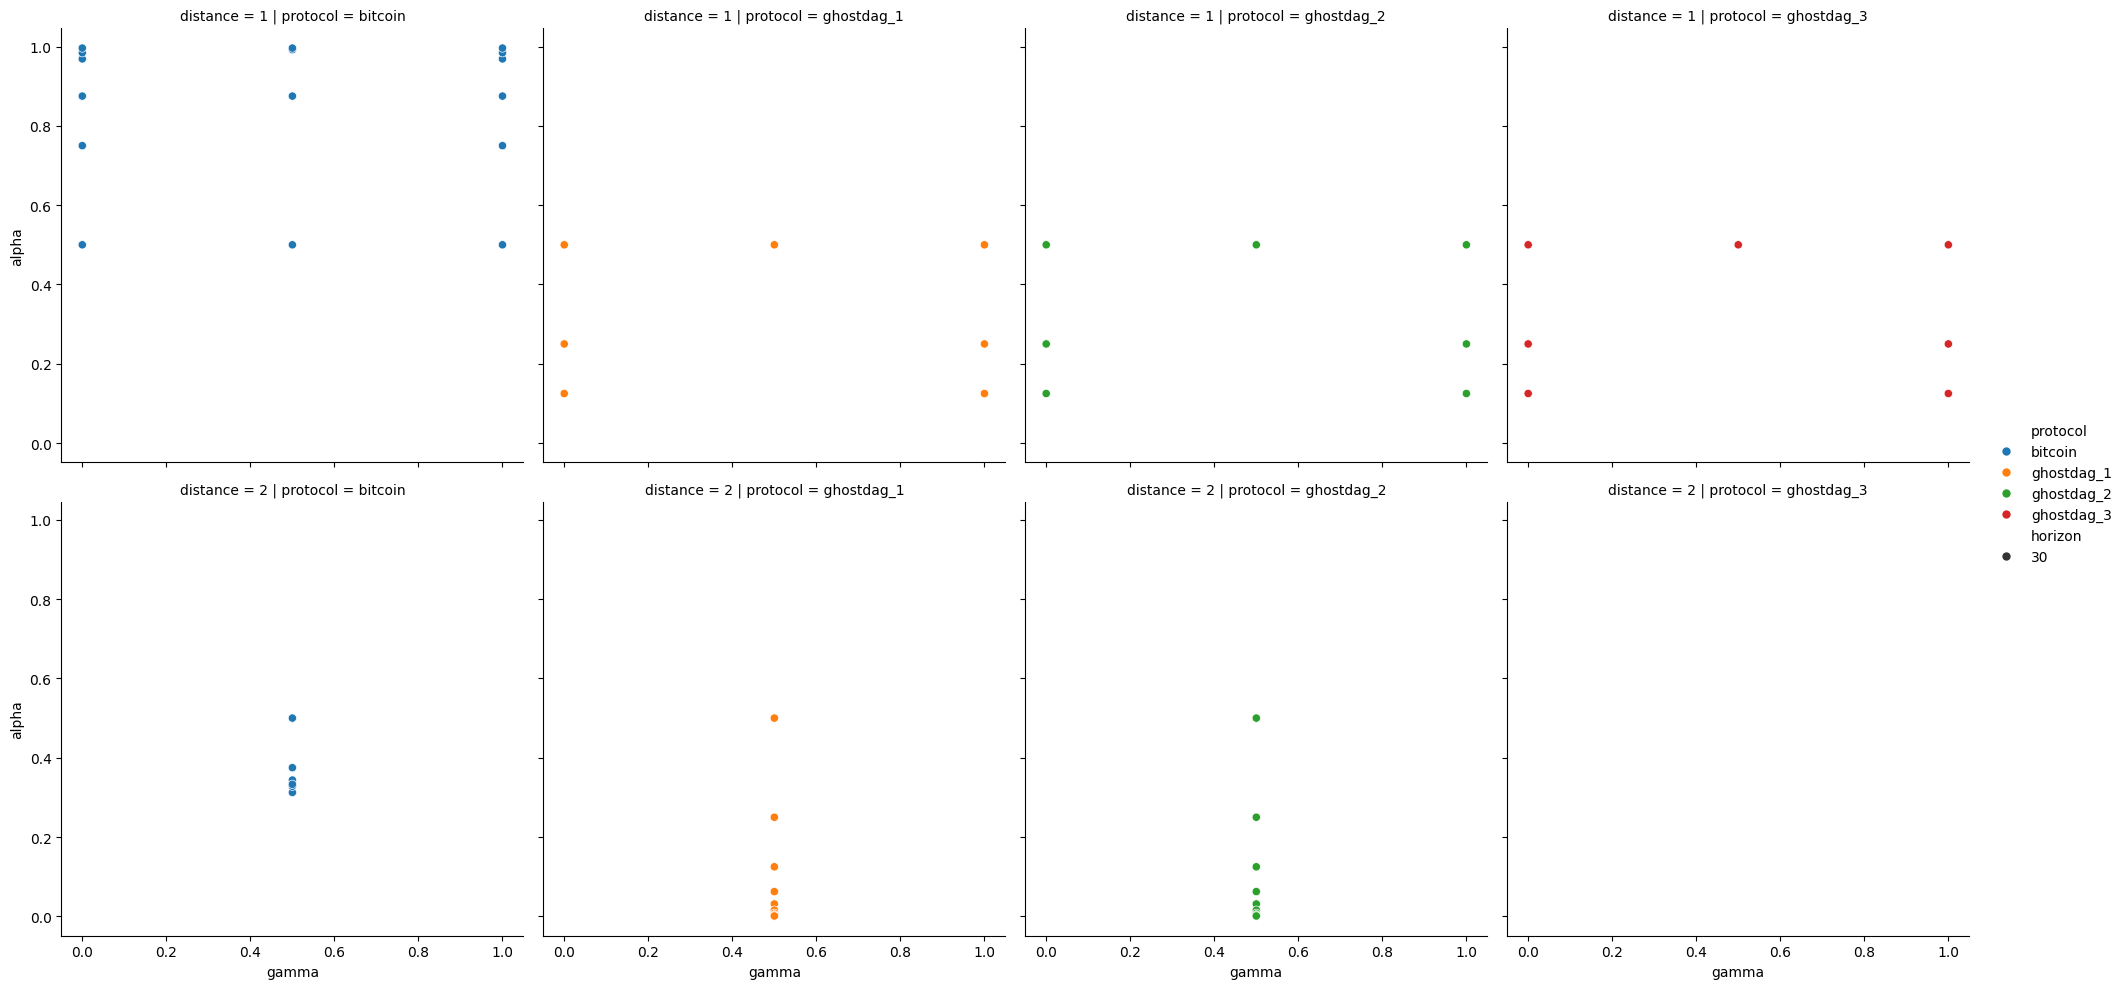

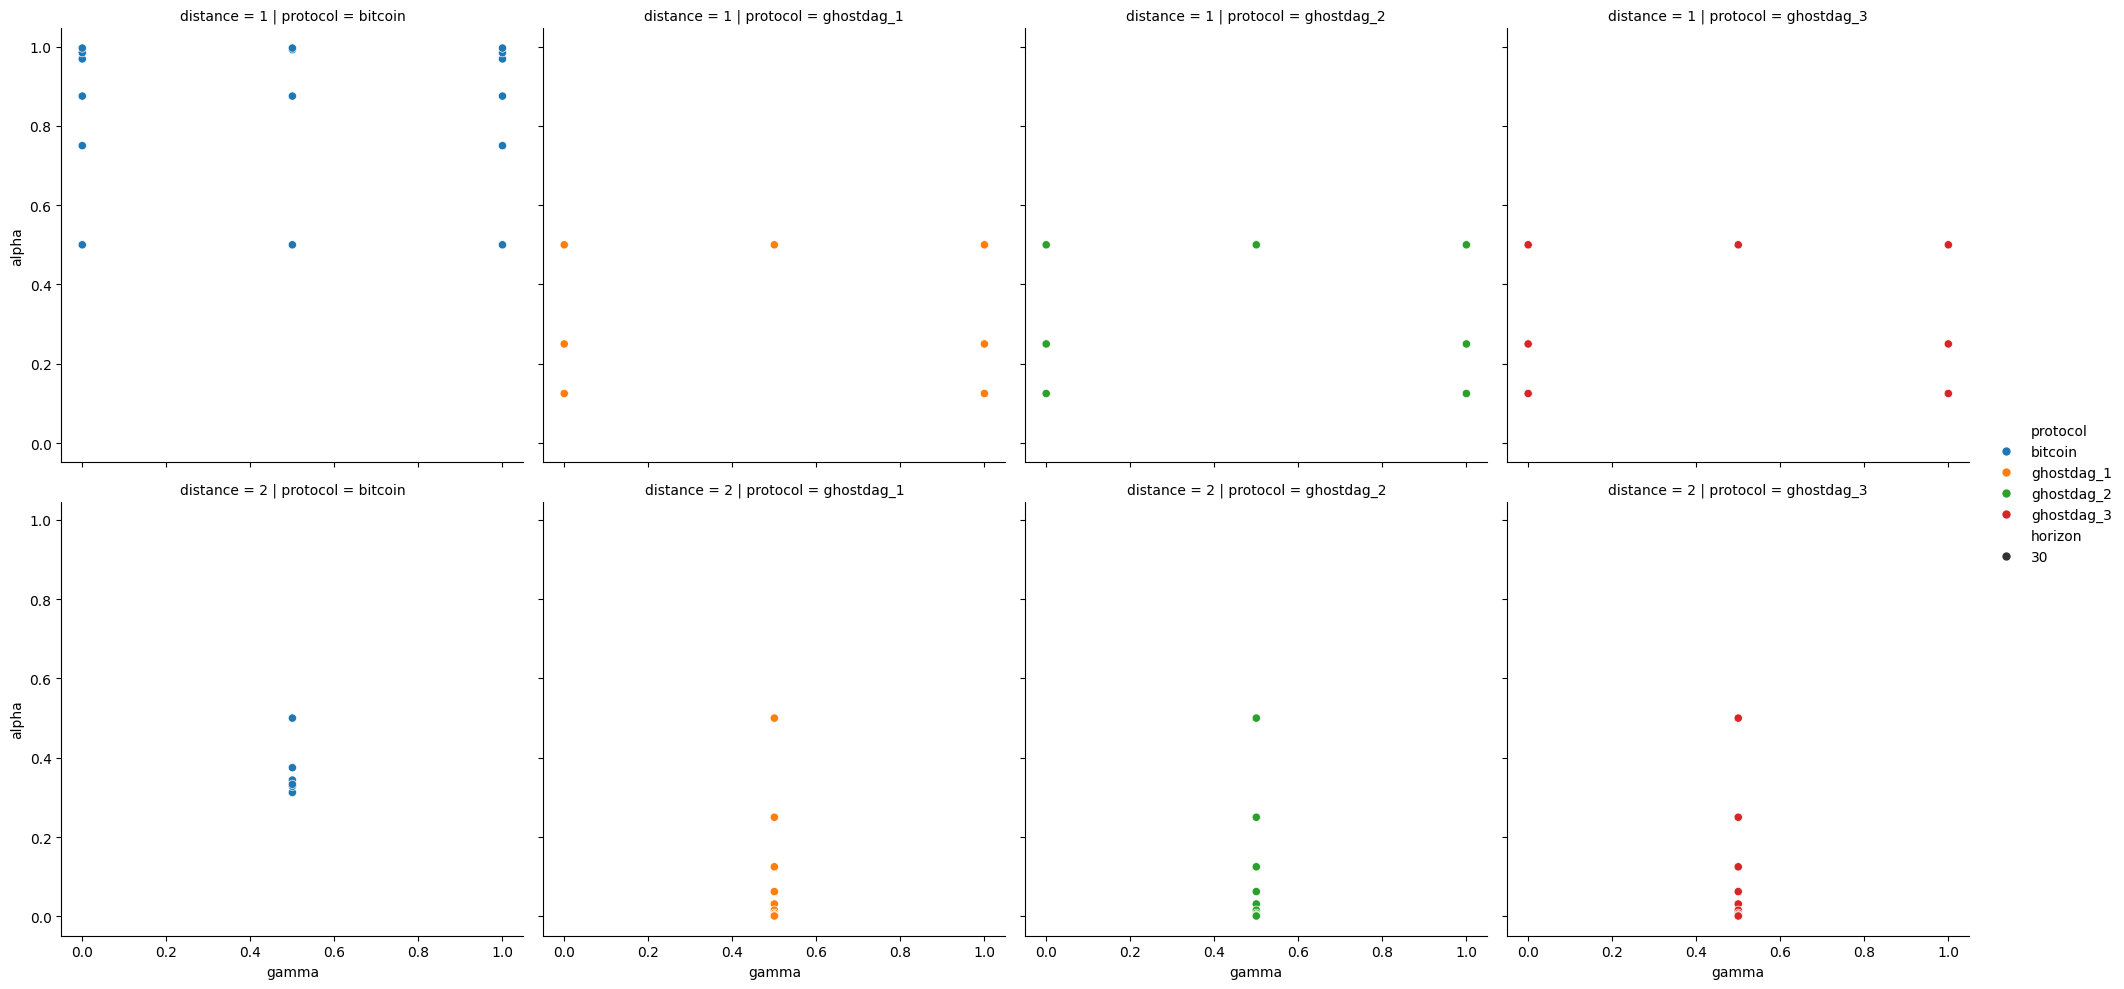

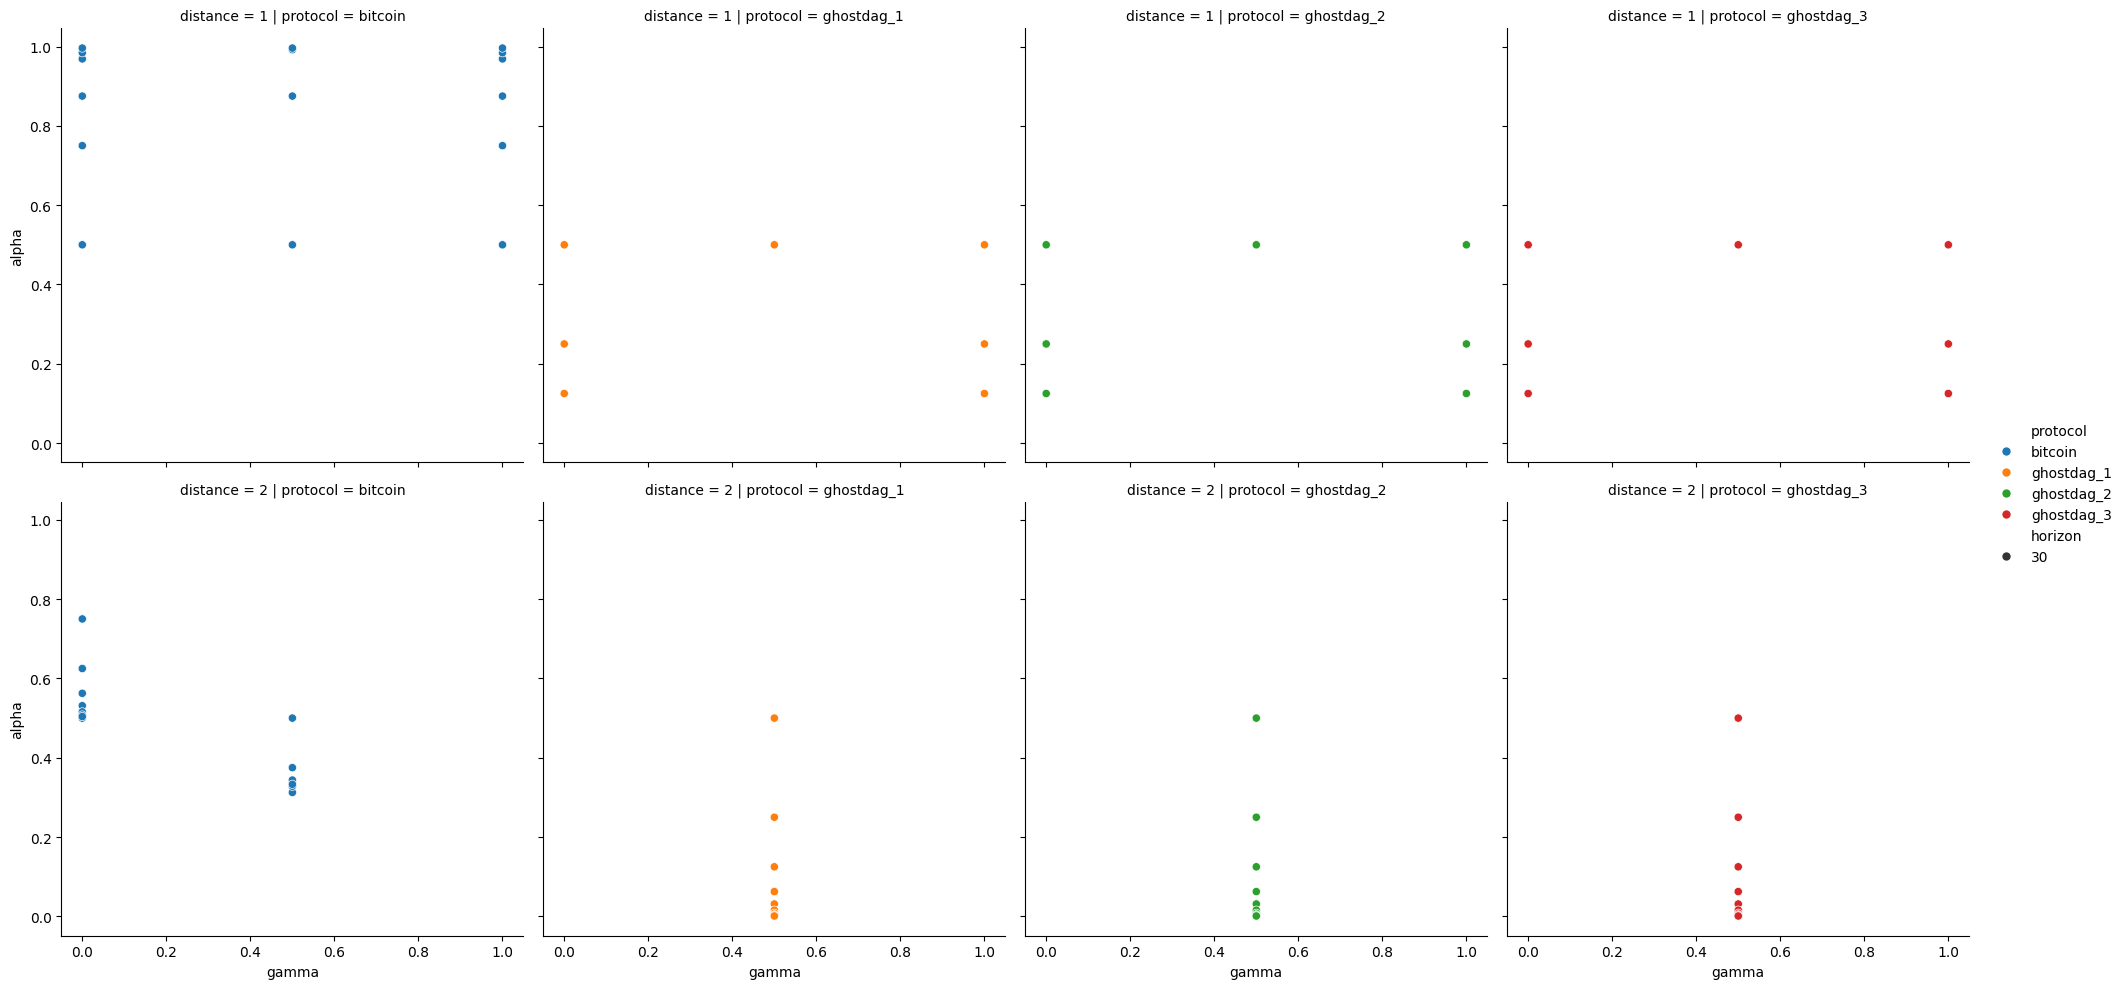

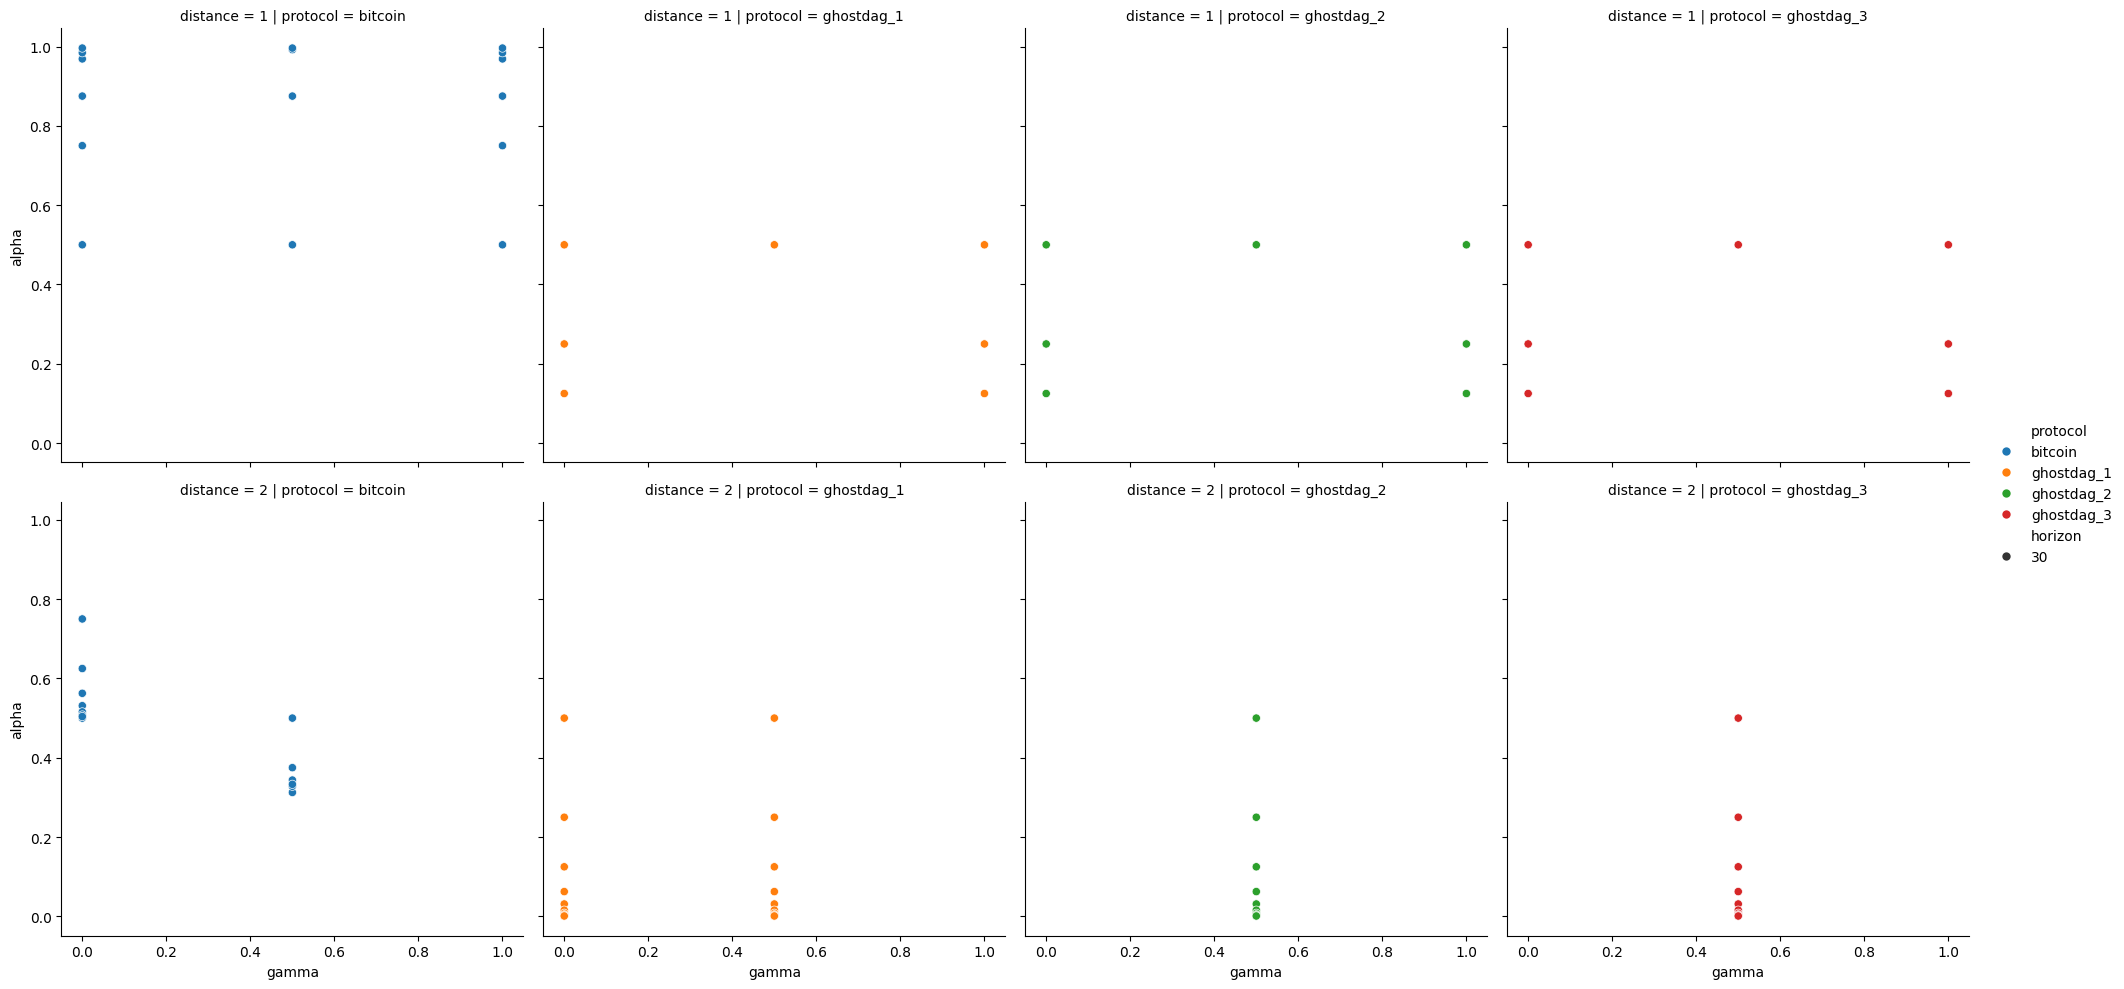

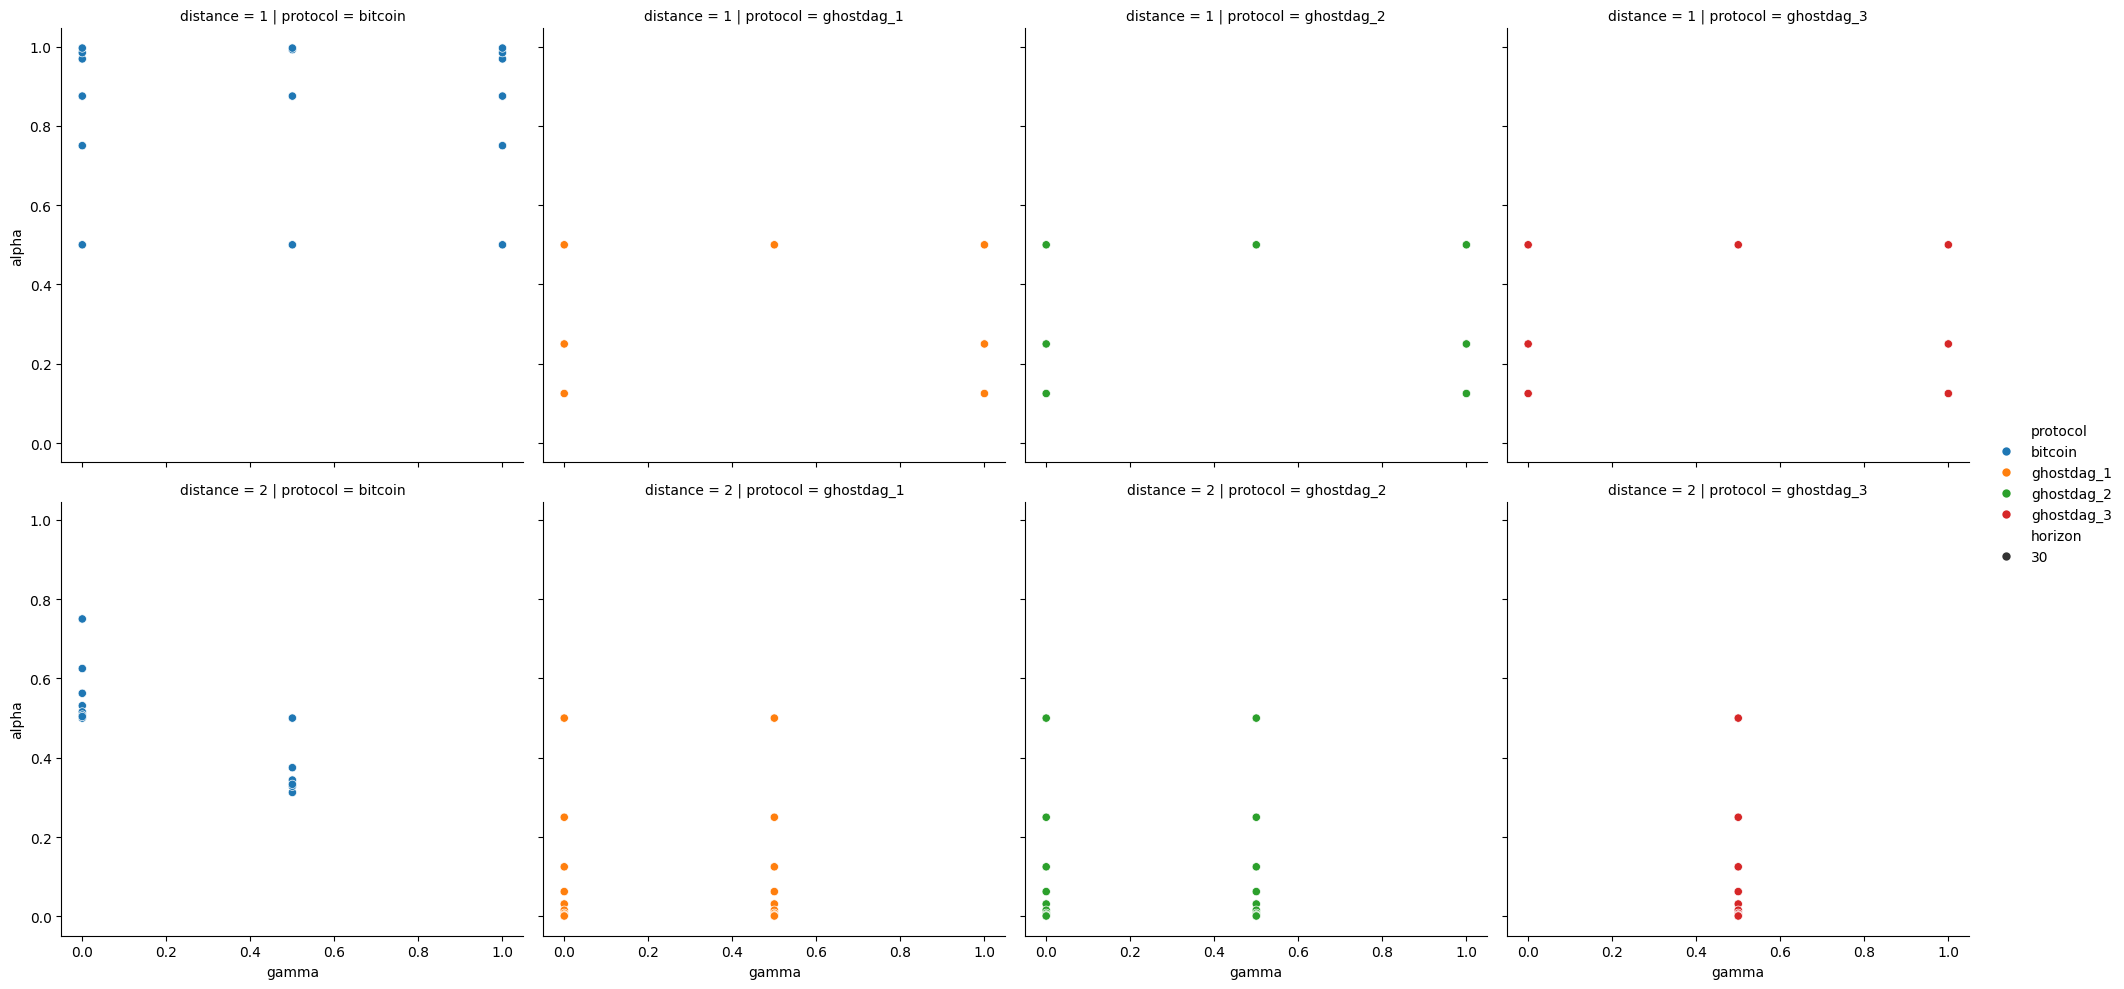

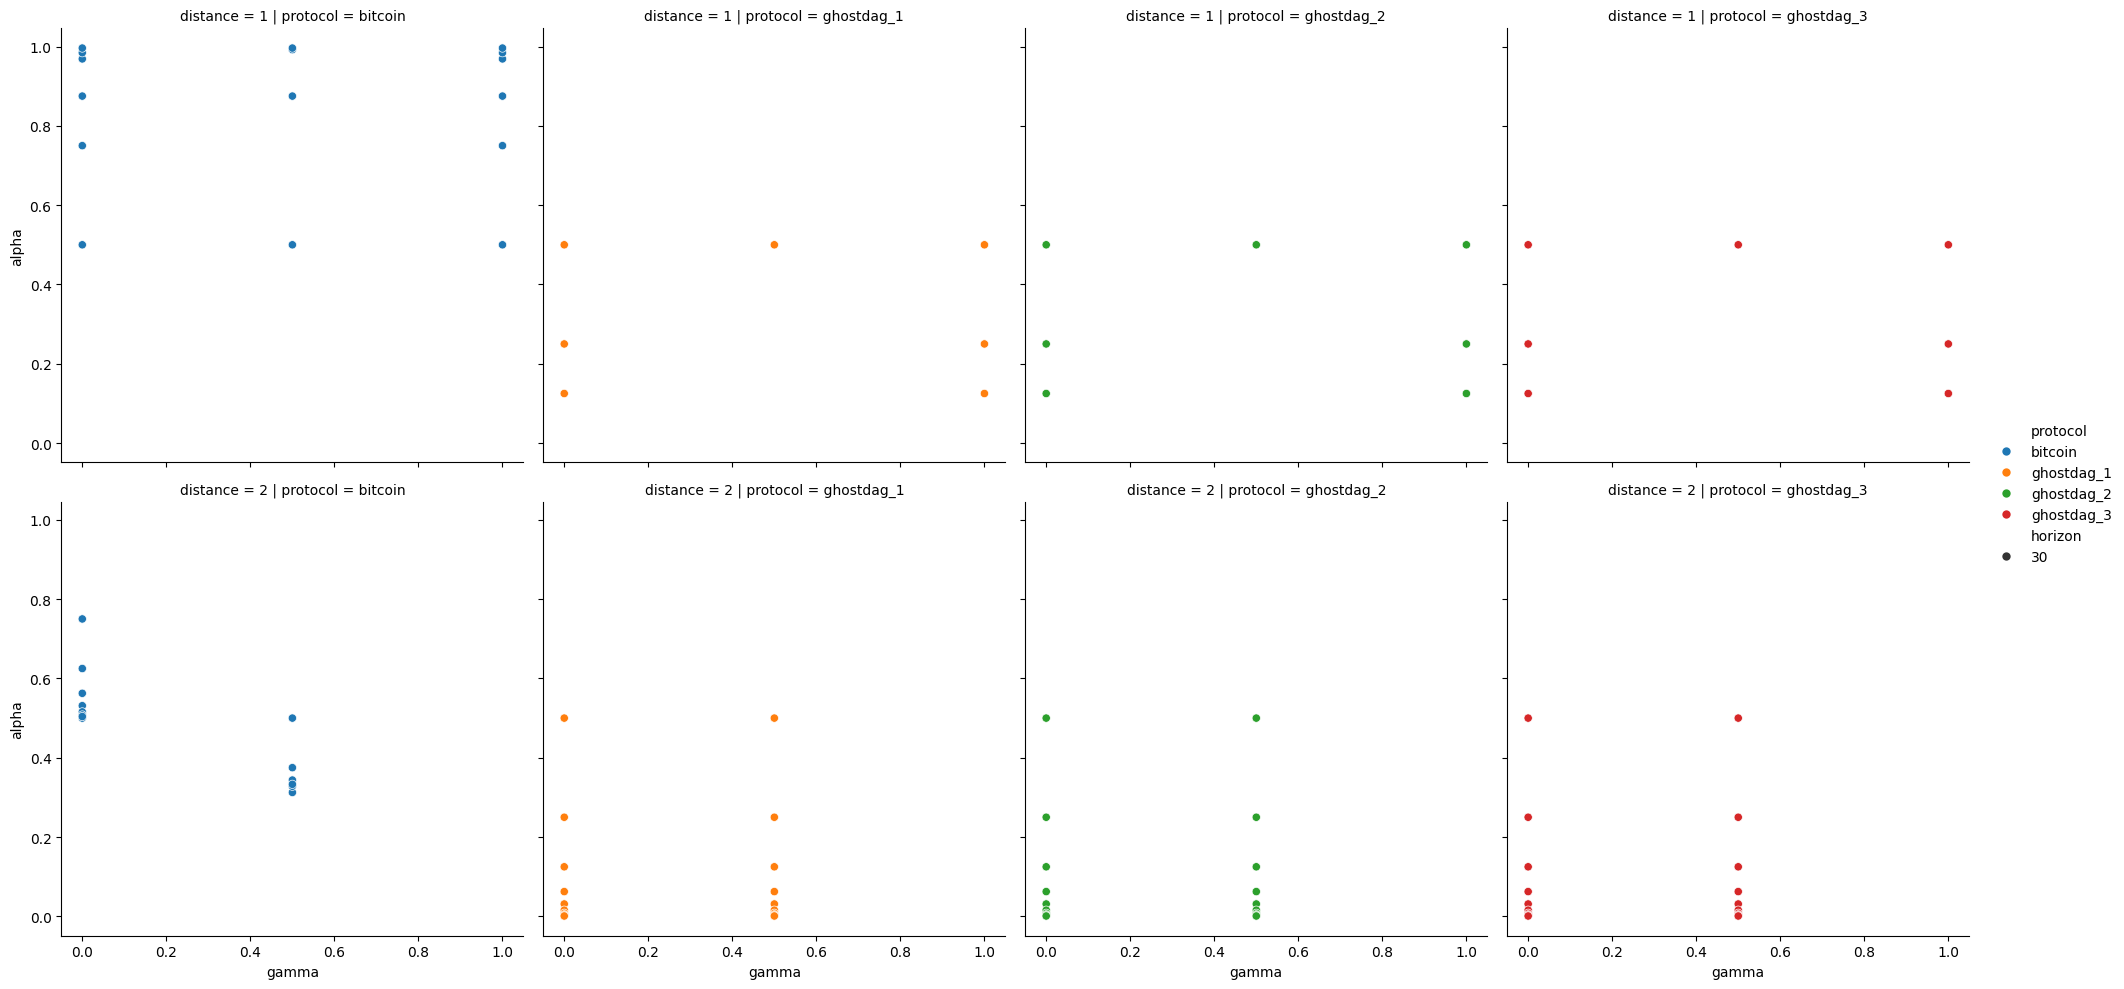

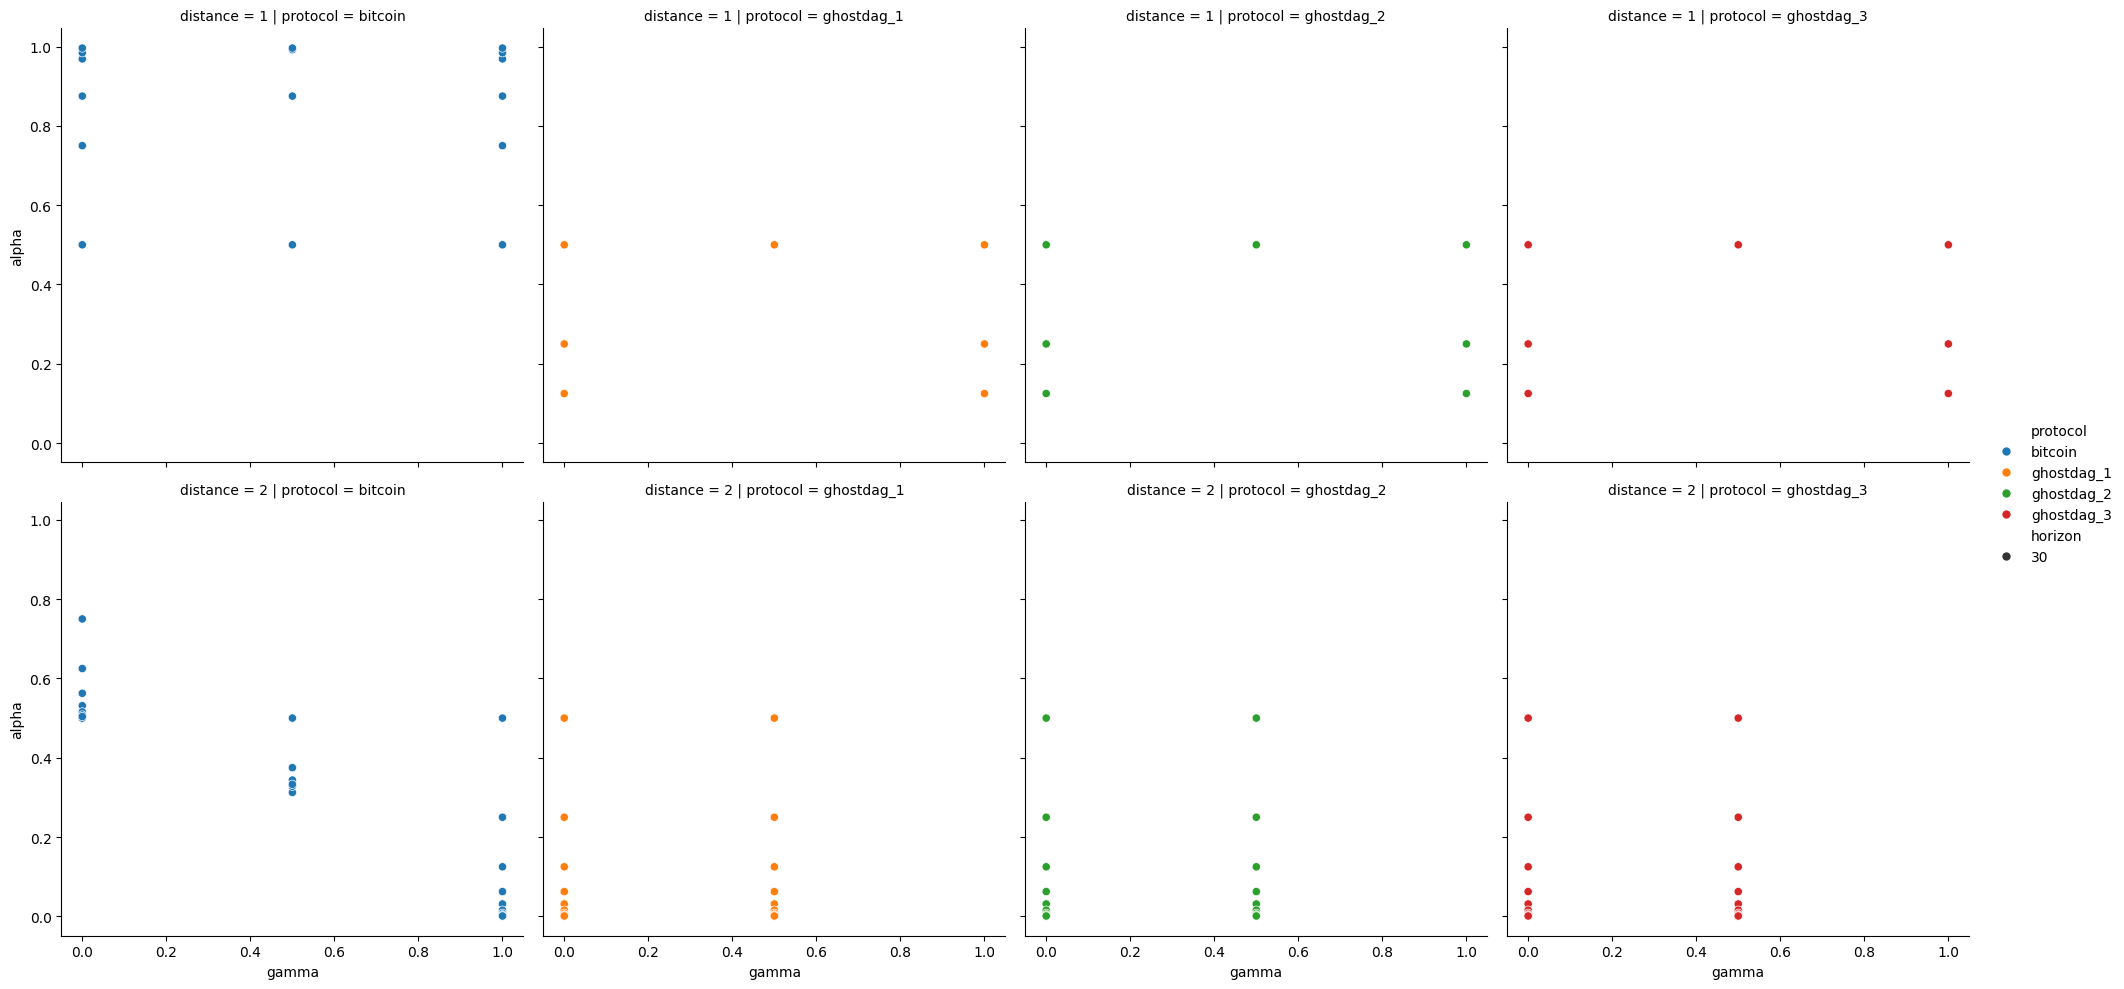

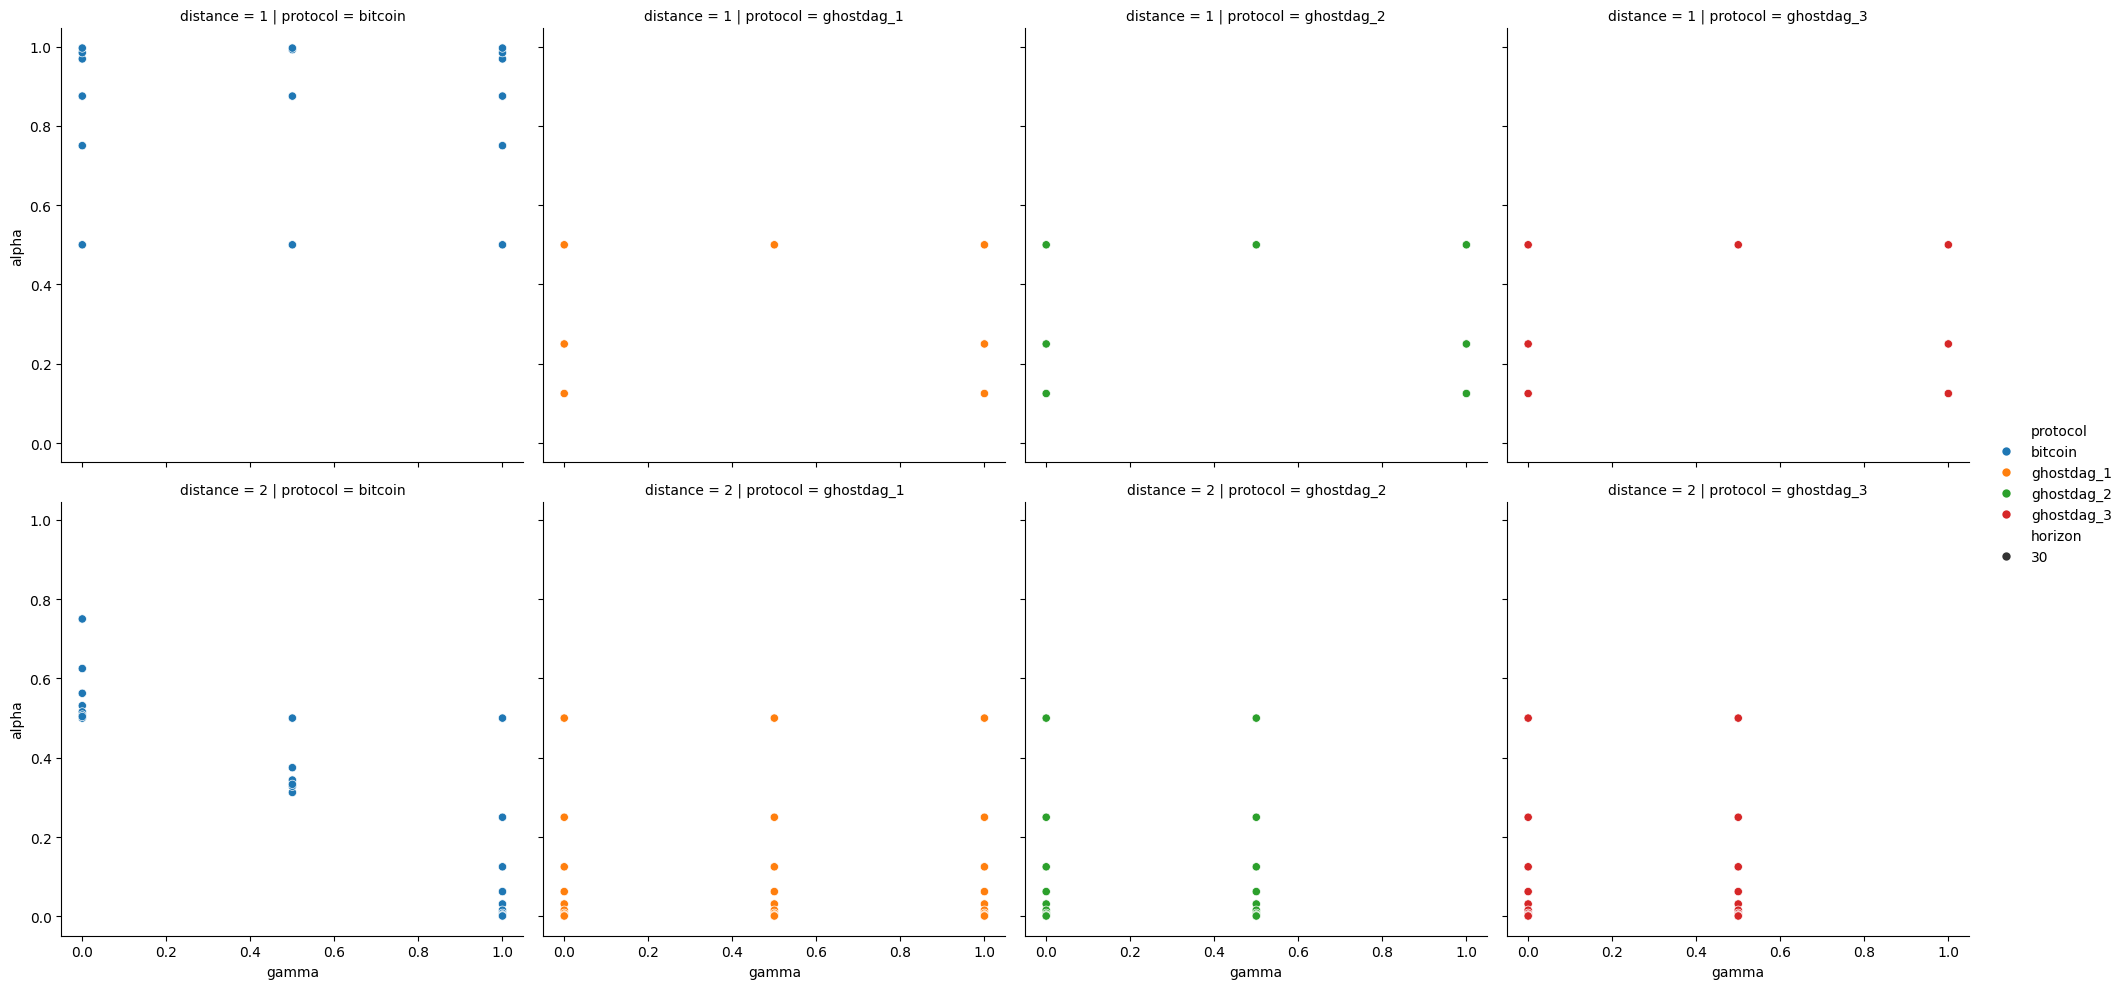

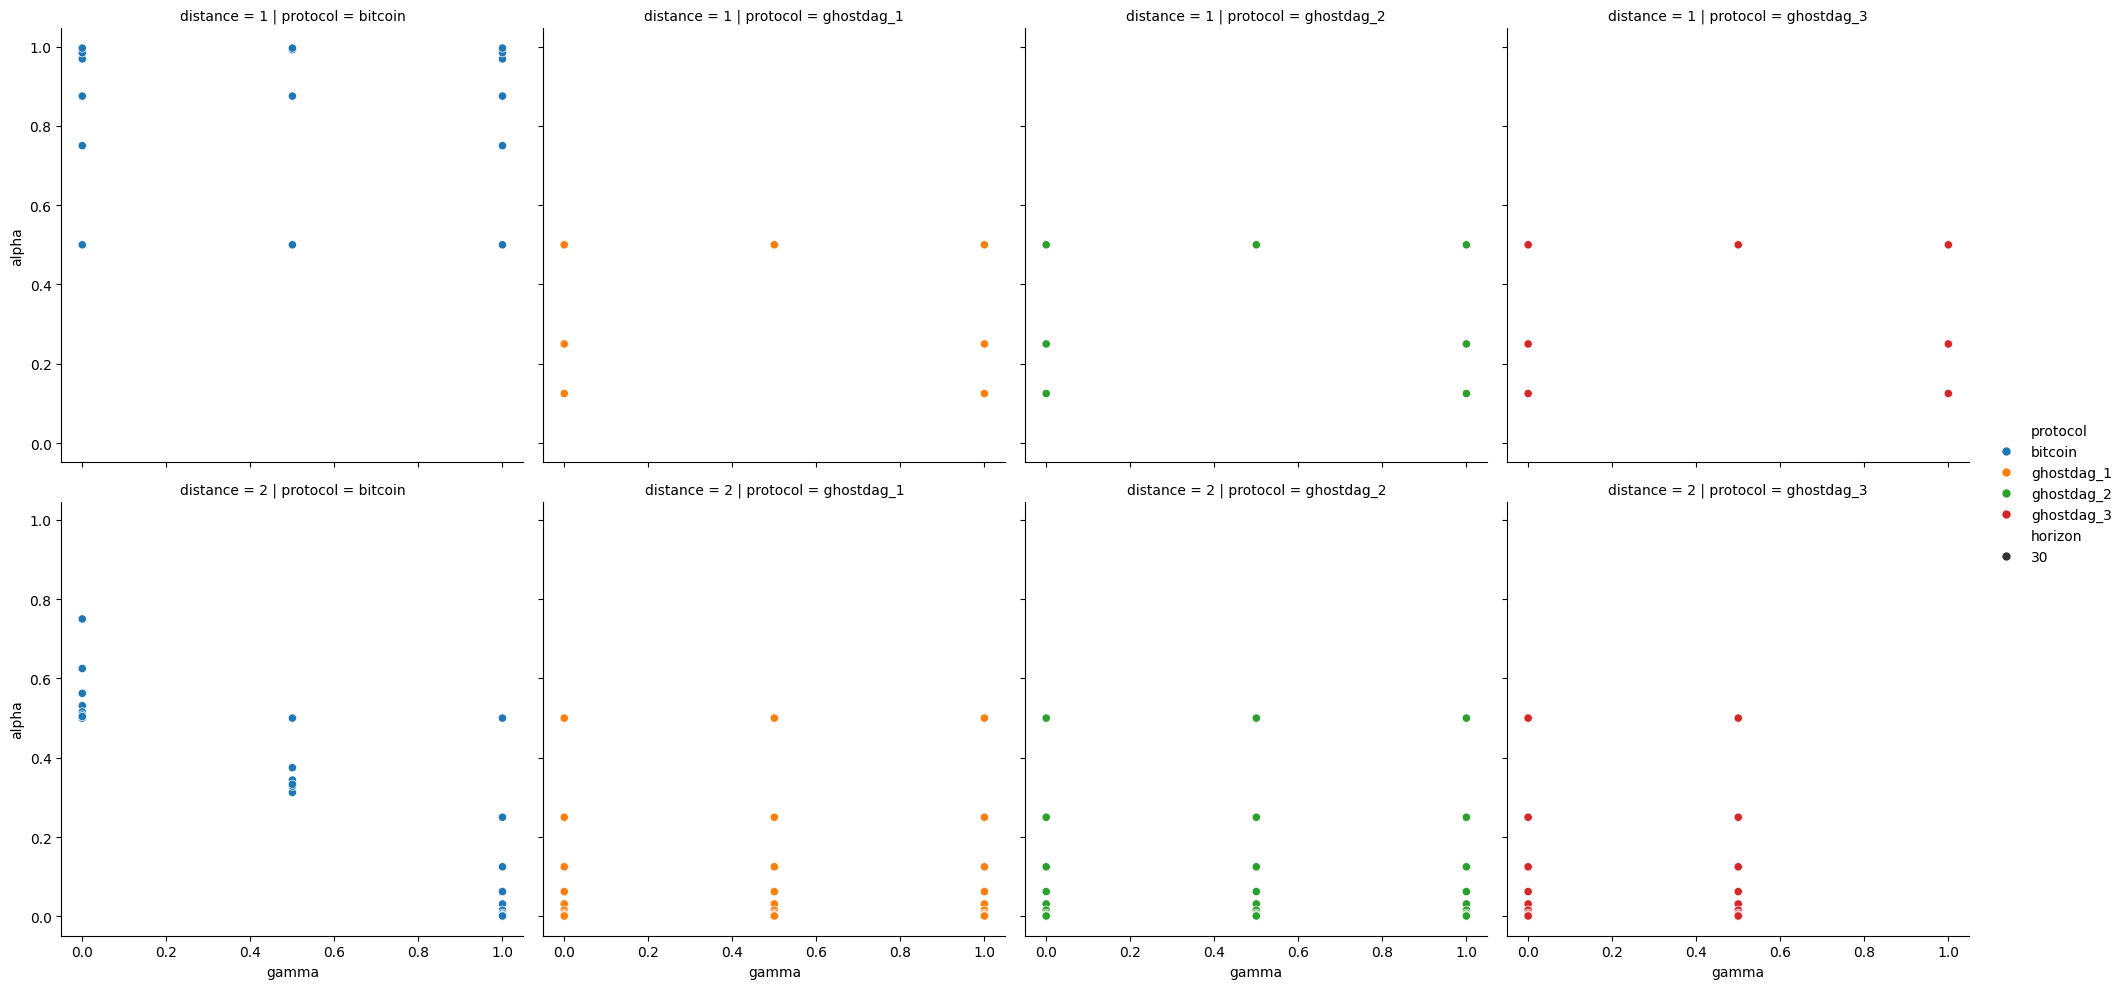

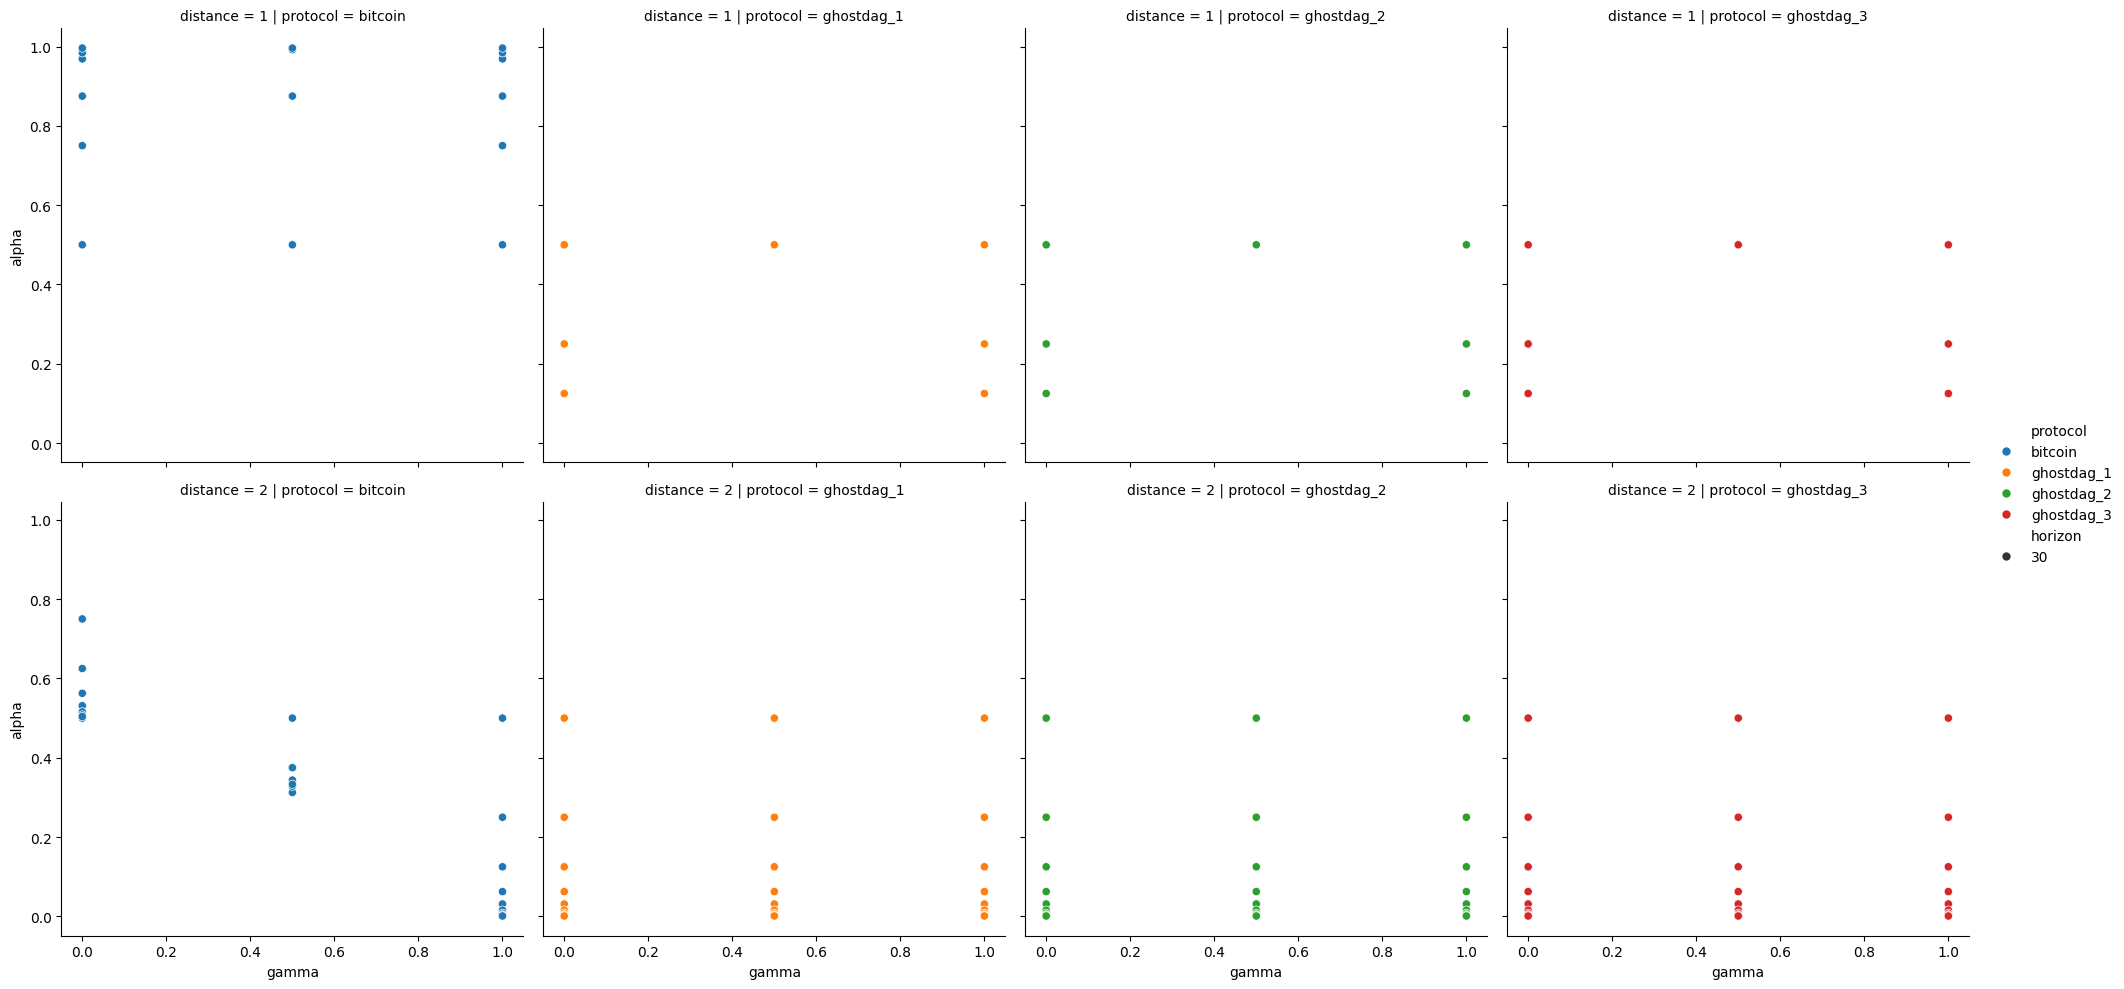

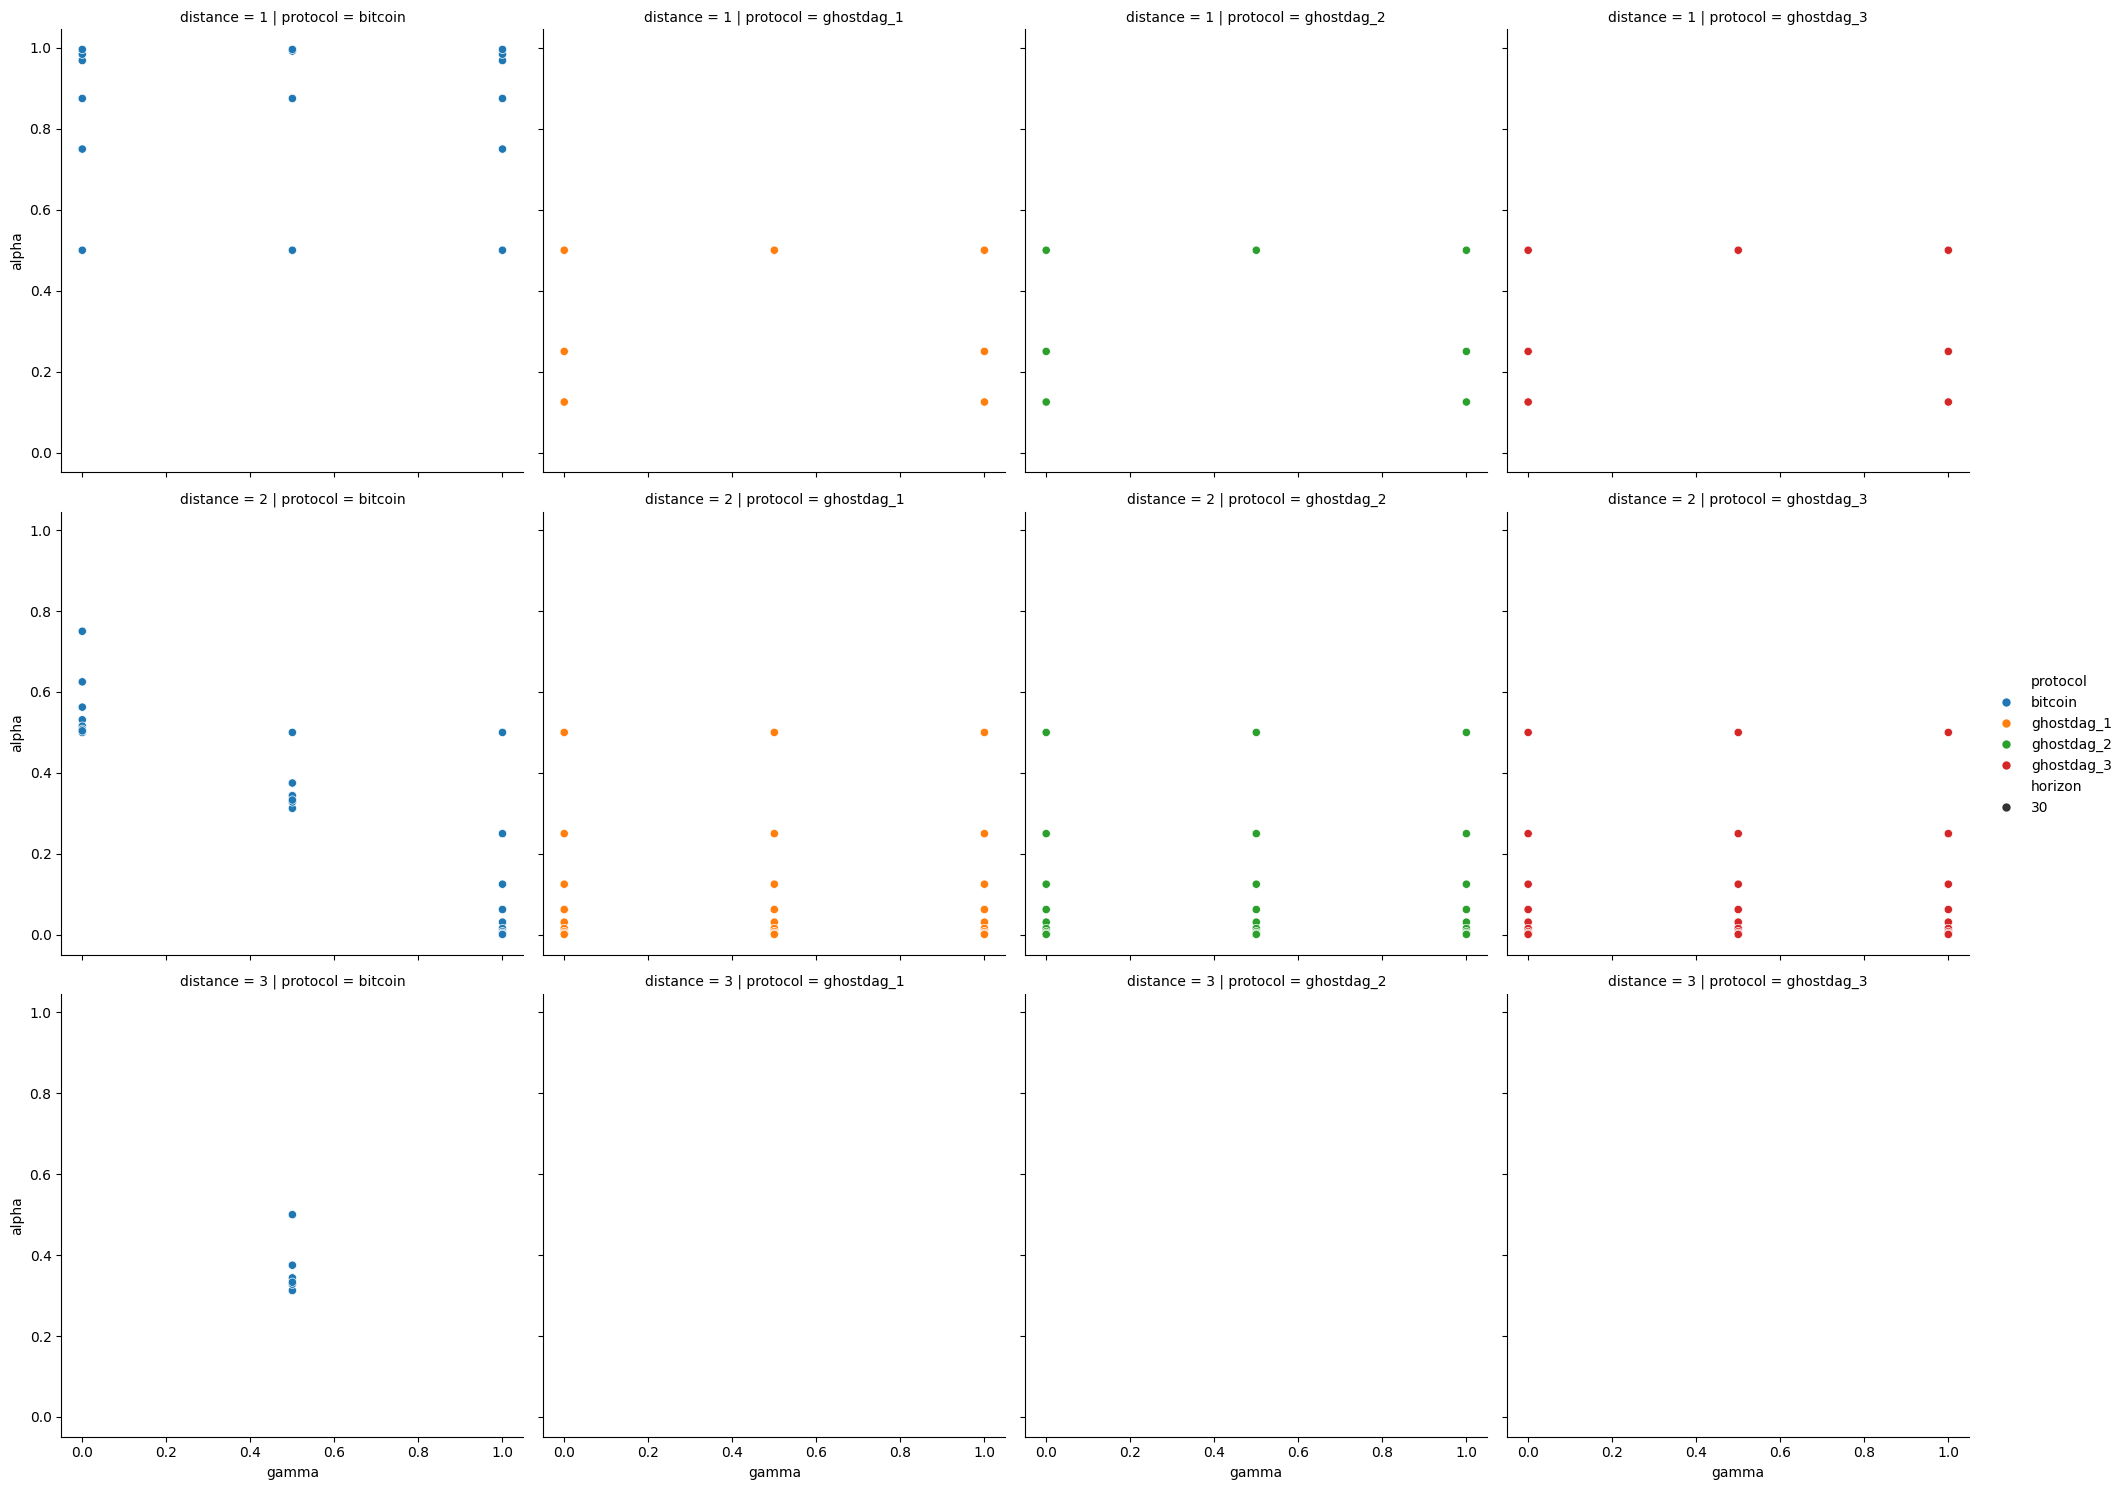

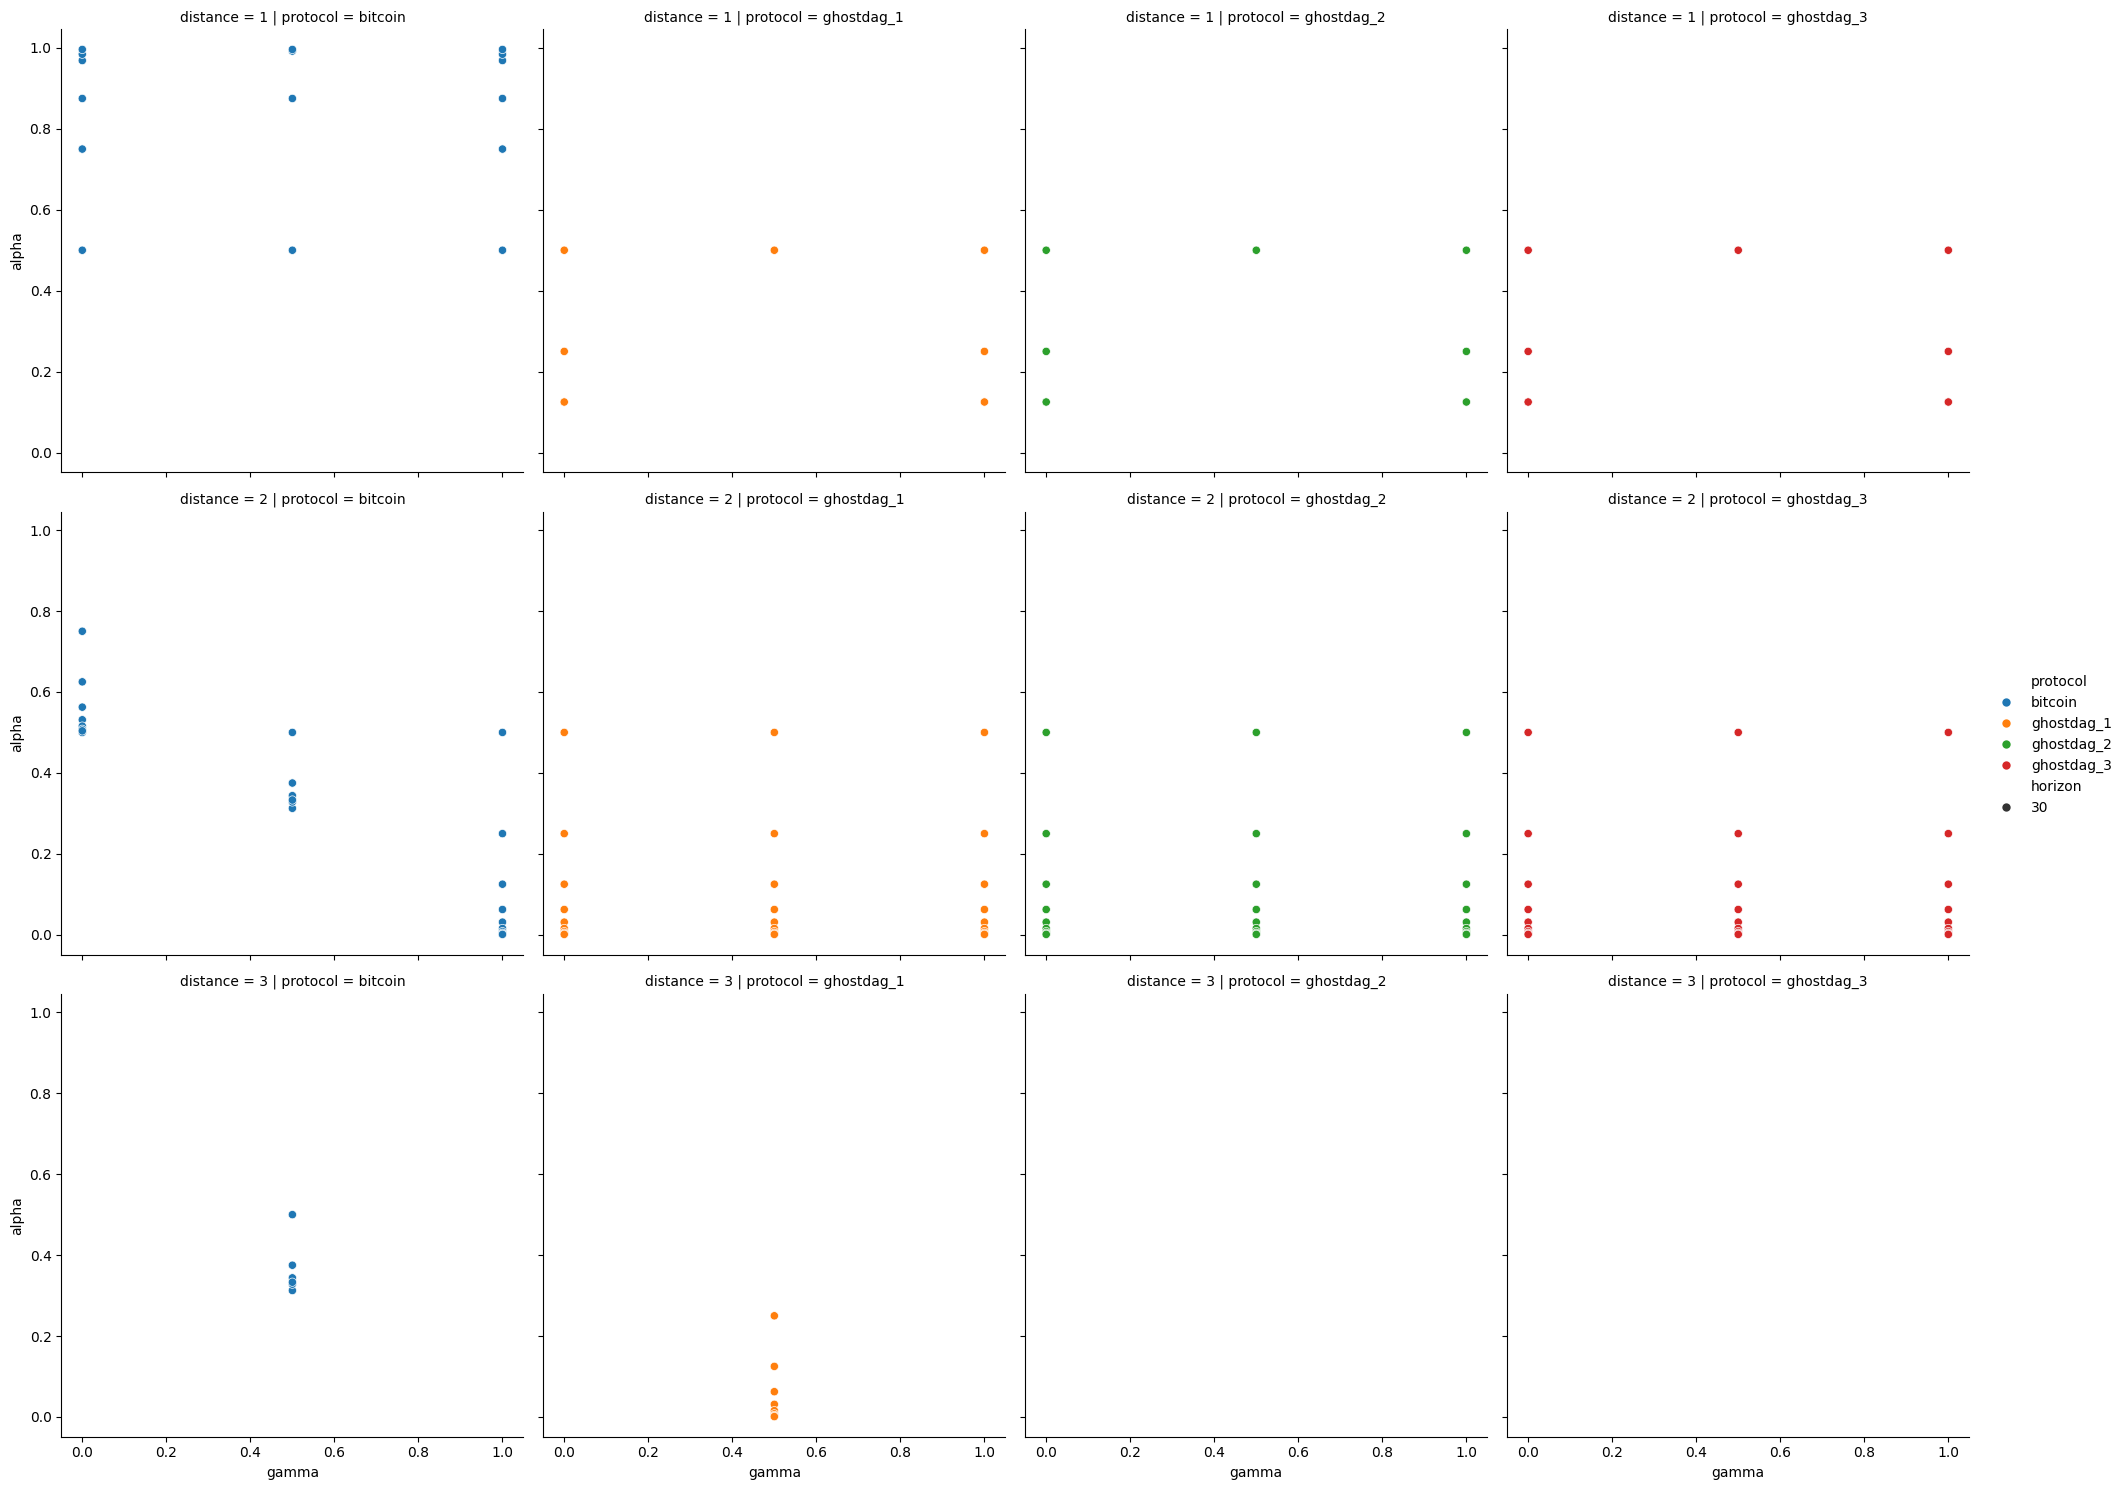

In [73]:
from IPython import display
import matplotlib.pyplot as plt

for d in explore_gen():
    bisect_alpha(**d)
    seaborn.relplot(
        data=pandas.DataFrame(evaluations).query(
            "reward_per_progress > alpha and horizon == 30"
        ),
        x="gamma",
        y="alpha",
        hue="protocol",
        style="horizon",
        row="distance",
        col="protocol",
    )
    display.clear_output(wait=True)
    display.display(plt.gcf())